In [4]:
import torch.nn as nn
import torch.nn.functional as F
import math
from torchvision import transforms
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from data import *
device  = 'cuda'
import matplotlib.pyplot as plt
import pandas as pd
import plotly
import plotly.express as px
import tqdm
import seaborn as sns
from torchvision.utils import make_grid
import os
import json
from torch import optim
from infomec import *
from blocks import *
from model import *
from accelerate import Accelerator
accelerator = Accelerator()
from fast_data import*

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [2]:
usimgs,uslabels,usone_hot_labels = get_data(40000,'cpu',True)
size = 4800
simgs,slabels,sone_hot_labels = get_data(size,'cpu',True)
split = 4500
trimgs,eimgs = simgs[:split],simgs[split:]
trlabels,elabels = slabels[:split],slabels[split:]
trone_hot_labels,eone_hot_labels = sone_hot_labels[:split],sone_hot_labels[split:]

In [25]:
ds = shapes3d_dataset()

In [10]:

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        #inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        #print(input_shape)
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))


        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs,reduction = 'mean')
        q_latent_loss = F.mse_loss(quantized, inputs.detach(),reduction = 'mean')
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized, perplexity, encodings,encoding_indices

In [62]:
femb.grad,finp.grad

(None, None)

In [188]:
torch.sum(torch.abs(femb.grad))

tensor(8.1300)

In [187]:
torch.sum(torch.abs(finp.grad))

tensor(8.4021)

In [181]:
femb.grad[femb.grad>0].shape

torch.Size([326])

In [173]:
torch.ones(12)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [61]:
femb = torch.rand(512,64)
finp = torch.rand(12,64)
femb.requires_grad = True
finp.requires_grad = True
# distances = (torch.sum(finp**2, dim=1, keepdim=True) 
#             + torch.sum(femb**2, dim=1)
#             - 2 * torch.matmul(finp, femb.T))

In [49]:
torch.norm(l2norm(femb),dim = 1).shape

torch.Size([512])

In [51]:
encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

encodings = torch.zeros(encoding_indices.shape[0], 512, device=finp.device)
encodings.scatter_(1, encoding_indices, 1)

torch.Size([12, 64])

In [63]:
cdist = l2norm(finp)@l2norm(femb).T
cdist.shape

torch.Size([12, 512])

In [65]:
# distances.shape
encoding_indices = torch.argmax(cdist, dim=1).unsqueeze(1)

encodings = torch.zeros(encoding_indices.shape[0], 512, device=finp.device)
encodings.scatter_(1, encoding_indices, 1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [74]:
torch.mean((cdist - encodings)**2)

tensor(0.5687, grad_fn=<MeanBackward0>)

In [152]:
closs = (cdist - encodings).sum()

In [154]:
closs.backward()

In [148]:
encodings.shape

(torch.Size([12, 512]), torch.Size([12, 512]))

In [134]:
abc = torch.tensor(([1,2.,3],[4,5,6],[7,8,9]),requires_grad = True)

In [136]:
loss = abc[1,1] - 10.0
loss.backward()

In [137]:
abc.grad

tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]])

In [96]:
encodings.shape,cdist.shape

(torch.Size([12, 512]), torch.Size([12, 512]))

In [97]:
ind = torch.argmin(cdist, dim=1).unsqueeze(1)


In [105]:
cdist[2,ind[2]]

tensor([0.6211])

In [177]:
closs =  (torch.ones(12) - torch.gather(cdist,1,encoding_indices).squeeze(1)).sum()
closs.backward()

In [178]:
closs

tensor(1.6538, grad_fn=<SumBackward0>)

In [73]:
cdist[:,encoding_indices.squeeze(0)].shape

torch.Size([12, 12, 1])

In [94]:
cdist.shape,ind.shape

(torch.Size([12, 512]), torch.Size([12, 1]))

In [15]:
encodings.shape

torch.Size([1024, 512])

In [26]:
def l2norm(t):
    return F.normalize(t, p = 2, dim = 1)

class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens,groups = groups):
        super(Decoder, self).__init__()
        #print(num_hiddens//2)
        self.gn1 = nn.GroupNorm(groups, 6)

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=3,
                                 stride=1, padding=1,groups = groups)
        self.gn2 = nn.GroupNorm(groups, num_hiddens//2)

        self.dconv1 = deconv_block(num_hiddens//2,num_hiddens//4)
        self.dconv2 = deconv_block(num_hiddens//4,num_hiddens//8)
        self.dconv3 = deconv_block(num_hiddens//8,num_hiddens//16)
        self.output = nn.Conv2d(in_channels = num_hiddens//16,
                                out_channels = 3,kernel_size = 1,stride = 1)
        
        
    def forward(self, inputs):
        inputs = self.gn1(inputs)
        x = F.gelu(self._conv_1(inputs))
        x = self.gn2(x)
        x = self.dconv1(x)
        x = self.dconv2(x)
        x = self.dconv3(x)
        return self.output(x)


In [27]:
class AttributeQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost,dist_type = 'cosine'):
        super(AttributeQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        #self._embedding.weight.data = emb_init
        # self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        nn.init.orthogonal_(self._embedding.weight)
        self._embedding.weight.requires_grad = False

        self._commitment_cost = 1
        self.qloss = 0.000
        self.dist_type = dist_type
    def compute_distance(self,inp,labels = None):
        if self.dist_type == "l2":
            distances= (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight.data**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.data.t()))
            encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

            encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inp.device)
            encodings.scatter_(1, encoding_indices, 1)
            return distances,encoding_indices,encodings
            
        if self.dist_type == 'cosine':
            
            distances = l2norm(inp)@l2norm(self._embedding.weight.data).T
            if labels!=None: 
                encoding_indices = torch.argmax(distances, dim=1).unsqueeze(1)
                encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inp.device)
                encodings.scatter_(1, encoding_indices, 1)
            else:
                encoding_indices = torch.argmax(distances, dim=1).unsqueeze(1)
                encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inp.device)
                encodings.scatter_(1, encoding_indices, 1)
                
            return distances,encoding_indices,encodings
        
    def forward(self, inputs,labels):

        input_shape = inputs.shape

        flat_input = inputs.reshape(-1, self._embedding_dim).contiguous()

        distances,encoding_indices,encodings = self.compute_distance(flat_input,labels)

        if labels != None:
            #quantized = torch.matmul(labels.unsqueeze(0), self._embedding.weight).view(input_shape)
            # quantized = torch.matmul(labels.unsqueeze(1), self._embedding.weight).view(input_shape)
            quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)


            #q_latent_loss = F.l1_loss(quantized, inputs.detach(),reduction = 'mean')
            closs =  (torch.ones(distances.shape[0],device = flat_input.device) - torch.gather(distances,1,labels.unsqueeze(1)).squeeze(1)).mean()
            #closs = torch.sum((distances - encodings)**2)
            # closs.backward()
            
            # q_latent_loss = F.mse_loss(quantized, inputs.detach(),reduction = 'mean')
            # e_latent_loss = F.mse_loss(quantized.detach(), inputs,reduction = 'mean')# + F.mse_loss(distances,labels,reduction = 'sum')
            loss = closs
            quantized = inputs + (quantized - inputs).detach()
            #avg_probs = torch.mean(encodings, dim=0)
            #avg_probs = torch.mean(labels.unsqueeze(0), dim=0)        
            perplexity = torch.tensor(1)#torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
            
            # convert quantized from BHWC -> BCHW
            return loss, quantized, perplexity,encodings,encoding_indices#, encodings,encoding_indices#,None
        
        # encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        # encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        # encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs,reduction = 'mean')
        q_latent_loss = F.mse_loss(quantized, inputs.detach(),reduction = 'mean')
        #loss = q_latent_loss + self._commitment_cost * e_latent_loss
        #loss = e_latent_loss*self._commitment_cost + q_latent_loss*self.qloss
        closs =  (torch.ones(distances.shape[0],device = flat_input.device) - torch.gather(distances,1,encoding_indices).squeeze(1)).mean()
        loss = closs

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized, perplexity, encodings,encoding_indices

In [28]:
class attribute_encoder(nn.Module):
    def __init__(self,in_channels,groups = 6):
        super(attribute_encoder,self).__init__()
        self.conv1 = conv_block(in_channels = in_channels,
                               out_channels = 20)
        self.conv2 = conv_block(in_channels = 20,
                                out_channels = 40)
        self.conv3 = conv_block(in_channels = 40,out_channels = 120)
        #self.res_stack = ResidualStack(120,120,num_residual_layers,120)
        self.gconv1 = group_conv_block(in_channels = 120,out_channels = 60,kernel = 3, stride = 1,padding = 1,groups = 6)
        self.gn1 = nn.GroupNorm(6,60)
        self.gconv4 = group_conv_block(in_channels = 60,out_channels = 6,kernel = 1,stride = 1,groups = 6,padding = 0)
        self.gn2 = nn.GroupNorm(6,6)
    def forward(self,x):
        z = self.conv1(x)
        z = self.conv2(z)
        z = self.conv3(z)
        #z = self.res_stack(z)
        # print(z.shape)
        # latent = F.gelu(self.gn1(self.gconv1(z)))
        z = F.gelu(self.gn1(self.gconv1(z)))

        
        z = self.gconv4(z)
        z = self.gn2(z)
        return z#,z.view(-1,6)

In [58]:
class AE(nn.Module):
    def __init__(self, num_hiddens, embedding_dim, commitment_cost,dist_type = 'cosine'):
        super(AE, self).__init__()
        self.encoder = attribute_encoder(3,groups = 6)
        self.decoder = Decoder(6,num_hiddens,6)
        self.embedding_dim = embedding_dim
        self.dist_type = dist_type
        self.vq1 = AttributeQuantizer(10,64,0.25)
        
        self.vq2 = VectorQuantizer(10,64,0.25)
        self.vq3 = VectorQuantizer(10,64,0.25)
        
        self.vq4 = AttributeQuantizer(8,64,0.25)
        self.vq5 = AttributeQuantizer(4,64,0.25)
        self.vq6 = AttributeQuantizer(15,64,0.25)

    def forward(self,x,labels = None):
        latent = self.encoder(x)
        #print(latent.shape)
        #return latent,self.decoder(latent)
        q = torch.zeros(latent.shape).to(device)

        if labels != None:
            loss0, q[:,0,:], perplexity0, encodings0,encoding_indices0 = self.vq1(latent[:,0,:],labels[:,0])
            #loss1, q[:,1,:], perplexity1, encodings1,encoding_indices1 = self.vq2(latent[:,1,:],labels[:,1])
            #loss2, q[:,2,:], perplexity2, encodings2,encoding_indices2 = self.vq3(latent[:,2,:],labels[:,2])
            loss3, q[:,3,:], perplexity3, encodings3,encoding_indices3 = self.vq4(latent[:,3,:],labels[:,3])
            loss4, q[:,4,:], perplexity4, encodings4,encoding_indices4 = self.vq5(latent[:,4,:],labels[:,4])
            loss5, q[:,5,:], perplexity5, encodings5,encoding_indices5 = self.vq6(latent[:,5,:],labels[:,5])
            loss1, q[:,1,:], perplexity1, encodings1,encoding_indices1 = self.vq2(latent[:,1,:])
            loss2, q[:,2,:], perplexity2, encodings2,encoding_indices2 = self.vq3(latent[:,2,:])
            
        else:
            loss0, q[:,0,:], perplexity0, encodings0,encoding_indices0 = self.vq1(latent[:,0,:],labels)
            loss1, q[:,1,:], perplexity1, encodings1,encoding_indices1 = self.vq2(latent[:,1,:])
            loss2, q[:,2,:], perplexity2, encodings2,encoding_indices2 = self.vq3(latent[:,2,:])
            loss3, q[:,3,:], perplexity3, encodings3,encoding_indices3 = self.vq4(latent[:,3,:],labels)
            loss4, q[:,4,:], perplexity4, encodings4,encoding_indices4 = self.vq5(latent[:,4,:],labels)
            loss5, q[:,5,:], perplexity5, encodings5,encoding_indices5 = self.vq6(latent[:,5,:],labels)

        #print(q)
        recon = self.decoder(q)
        return (recon,q,
        [loss0,loss1,loss2,loss3,loss4,loss5],
        [perplexity0,perplexity1,perplexity2,perplexity3,perplexity4,perplexity5],
        [encoding_indices0,encoding_indices1,encoding_indices2,encoding_indices3,encoding_indices4,encoding_indices5],
                [encodings0,encodings1,encodings2,encodings3,encodings4,encodings5])


            
num_hiddens = 120
num_residual_hiddens = 60
num_residual_layers = 2
ae = AE(120,64,0.25).to(device)
optimizer = optim.Adam(ae.parameters(), lr=0.001, amsgrad=False)

In [141]:
finp = torch.rand(12,3,64,64)
at_e = attribute_encoder(3,6)

In [107]:
latent,enc = at_e(finp)

ValueError: too many values to unpack (expected 2)

In [52]:
latent.shape,enc.shape

(torch.Size([12, 60, 8, 8]), torch.Size([12, 6, 8, 8]))

In [119]:
# def get_data(size,device = 'cuda',one_hot = False):
#     #size = 100
#     arng = torch.arange(size)
#     a1 = np.random.permutation(arng)%10
#     a2 = np.random.permutation(arng)%10
#     a3 = np.random.permutation(arng)%10
#     a4 = np.random.permutation(arng)%8
#     a5 = np.random.permutation(arng)%4
#     a6 = np.random.permutation(arng)%15
    
#     lab = np.stack([a1,a2,a3,a4,a5,a6],1)
#     ind = list(map(get_ind,lab))
#     file_path = '/mnt/beegfs/ksanka/data/3dshapes/3dshapes.h5'
#     with h5py.File(file_path, 'r') as file:
#         images = file['images'][:]
#         # raw_labels = file['labels'][:]
    
#     elabels = torch.from_numpy(lab+[0,10,20,30,38,42]).to(device)
#     labels = torch.from_numpy(lab).to(device)
#     img = torch.from_numpy(images[ind,:]).to(device).permute(0,3,1,2)/255.0
#     # if one_hot:
#     one_hot_labels = torch.nn.functional.one_hot(elabels, num_classes=57).sum(dim = 1).to(device).float()
#     return img,labels,one_hot_labels

In [118]:
recon, loss_list,perp_list,ei_list = ae(trimgs[perm].to(device))#,trlabels[perm].to(device))


In [161]:
quantized = torch.matmul(elist[0], ae.vq1._embedding.weight)


In [168]:
quantized[0]

tensor([-0.0574, -0.1653,  0.0218,  0.1017,  0.1453,  0.0612,  0.0548, -0.0796,
         0.1513, -0.2900,  0.1091,  0.1019, -0.0942,  0.0452,  0.2321,  0.0416,
        -0.0487,  0.0200,  0.0415,  0.0712,  0.1593,  0.2026,  0.0682, -0.0911,
        -0.1236, -0.0590,  0.0718, -0.2049,  0.0431,  0.0201,  0.0162,  0.2262,
        -0.0028, -0.0295, -0.1218,  0.0858, -0.0861,  0.2004,  0.2024, -0.1186,
         0.0055, -0.1135, -0.2117, -0.0197, -0.0807,  0.1309, -0.1084, -0.0730,
        -0.2083, -0.0581, -0.0645,  0.1073, -0.2979, -0.1193,  0.1816,  0.0214,
         0.0736, -0.1792,  0.0464,  0.1459, -0.0967, -0.0899,  0.0136, -0.1341],
       device='cuda:0')

In [165]:
ae.vq1._embedding.weight[1]

tensor([-0.0574, -0.1653,  0.0218,  0.1017,  0.1453,  0.0612,  0.0548, -0.0796,
         0.1513, -0.2900,  0.1091,  0.1019, -0.0942,  0.0452,  0.2321,  0.0416,
        -0.0487,  0.0200,  0.0415,  0.0712,  0.1593,  0.2026,  0.0682, -0.0911,
        -0.1236, -0.0590,  0.0718, -0.2049,  0.0431,  0.0201,  0.0162,  0.2262,
        -0.0028, -0.0295, -0.1218,  0.0858, -0.0861,  0.2004,  0.2024, -0.1186,
         0.0055, -0.1135, -0.2117, -0.0197, -0.0807,  0.1309, -0.1084, -0.0730,
        -0.2083, -0.0581, -0.0645,  0.1073, -0.2979, -0.1193,  0.1816,  0.0214,
         0.0736, -0.1792,  0.0464,  0.1459, -0.0967, -0.0899,  0.0136, -0.1341],
       device='cuda:0')

In [217]:
ei_list[0].shape

torch.Size([64, 1])

In [414]:
ae.encoder.conv1._block2[0].weight.grad

In [162]:
quantized.shape

torch.Size([64, 64])

In [120]:
torch.cat(ei_list,1)

torch.Size([64, 6])

In [8]:
usimgs,uslabels,usone_hot_labels = get_data(40000,'cpu',True)
size = 4800
simgs,slabels,sone_hot_labels = get_data(size,'cpu',True)
split = 4500
trimgs,eimgs = simgs[:split],simgs[split:]
trlabels,elabels = slabels[:split],slabels[split:]
trone_hot_labels,eone_hot_labels = sone_hot_labels[:split],sone_hot_labels[split:]

In [17]:
ds

In [423]:
print(ae.encoder.conv1._block2[0].weight.grad)     


None


In [124]:
device = 'cpu'

In [9]:
ae = AE(120,64,0.25).to(device)


In [53]:
ae = AE(120,64,0.25).to(device)
#optimizer = optim.Adam(ae.parameters(), lr=0.001, amsgrad=False)
optimizer = optim.AdamW(ae.parameters(), lr=0.001, weight_decay=0.3)
for name, param in ae.named_parameters():
    if "bias" in name:
        param.weight_decay = 0
    if "embedding" in name:
        param.weight_decay = 0
#print(ae.encoder.conv1._block2[0].weight.grad)     
step = 0
for i in tqdm.tqdm(range(10000),ncols = 100):
    step+=1
    perm = torch.randint(0,4500,(64,))

    #perm = torch.randint(0,size,(64,))
    optimizer.zero_grad()
    data,lab,_=  ds.get_sup_batch()
    data,lab = data.to(device),lab.to(device)
    #if training_mode == "s":
    recon, quant,loss_list,perp_list,ei_list,elist = ae(data,lab.long())
    #recon_loss = F.binary_cross_entropy_with_logits(recon,trimgs[perm].to(device),reduction = 'mean')
    recon_loss = torch.sqrt(F.mse_loss(recon,data,reduction = 'mean'))

    # else:
    #     recon, loss_list,perp_list,ei_list = ae(usimgs[perm].to(device))#,trone_hot_labels[perm].to(device))
    #     #recon_loss = F.binary_cross_entropy_with_logits(recon, usimgs[perm].to(device))
    #     recon_loss = F.mse_loss(recon, usimgs[perm].to(device))


    vq_loss = sum(loss_list)
    loss = recon_loss + vq_loss/6.
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(ae.parameters(), max_norm=1.0)
    
    optimizer.step()
    #recon_list.append(loss.item())
    if step %100 == 0:
        print(loss.item())
        print(recon_loss.item())
        print(loss_list)


  1%|▌                                                           | 98/10000 [00:05<09:21, 17.63it/s]

1.2748095989227295
0.3780340552330017


  1%|▌                                                          | 102/10000 [00:06<14:37, 11.28it/s]

[tensor(0.7261, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.1359, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1962, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.7946, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6189, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)]


  2%|█▏                                                         | 198/10000 [00:12<09:35, 17.02it/s]

1.226487159729004
0.2597215473651886


  2%|█▏                                                         | 202/10000 [00:12<14:47, 11.04it/s]

[tensor(0.7671, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.2443, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1946, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8947, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7562, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9436, device='cuda:0', grad_fn=<MeanBackward0>)]


  3%|█▊                                                         | 298/10000 [00:18<09:36, 16.82it/s]

1.212695837020874
0.20121583342552185


  3%|█▊                                                         | 302/10000 [00:18<13:54, 11.62it/s]

[tensor(0.7509, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.3827, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.3031, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.9016, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7854, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)]


  4%|██▎                                                        | 398/10000 [00:24<09:33, 16.74it/s]

1.2080615758895874
0.18174447119235992


  4%|██▎                                                        | 402/10000 [00:25<14:05, 11.35it/s]

[tensor(0.7402, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.4590, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.3101, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7807, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)]


  5%|██▉                                                        | 498/10000 [00:30<09:39, 16.40it/s]

1.194593906402588
0.18175870180130005


  5%|██▉                                                        | 502/10000 [00:31<14:04, 11.24it/s]

[tensor(0.7354, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.4180, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.2642, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.9229, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7819, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)]


  6%|███▌                                                       | 598/10000 [00:36<09:33, 16.40it/s]

1.1318964958190918
0.16685894131660461


  6%|███▌                                                       | 602/10000 [00:37<14:01, 11.16it/s]

[tensor(0.6907, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.3276, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1668, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8840, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7650, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)]


  7%|████▏                                                      | 700/10000 [00:42<11:07, 13.94it/s]

1.1187422275543213
0.18063661456108093
[tensor(0.6710, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.1945, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1323, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8834, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7930, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)]


  8%|████▋                                                      | 799/10000 [00:47<07:48, 19.64it/s]

1.0597602128982544
0.16383574903011322
[tensor(0.6912, device='cuda:0', grad_fn=<MeanBackward0>), tensor(1.1004, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.9724, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8664, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7936, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)]


  9%|█████▎                                                     | 899/10000 [00:53<09:02, 16.77it/s]

1.0009198188781738
0.157512828707695


  9%|█████▎                                                     | 903/10000 [00:54<13:31, 11.21it/s]

[tensor(0.6496, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9290, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8660, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7678, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)]


 10%|█████▉                                                     | 999/10000 [01:00<08:48, 17.03it/s]

0.9727610349655151
0.162008136510849


 10%|█████▊                                                    | 1003/10000 [01:00<13:03, 11.48it/s]

[tensor(0.6775, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8107, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.7404, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7492, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)]


 11%|██████▎                                                   | 1099/10000 [01:06<08:55, 16.61it/s]

0.8883470296859741
0.1433883011341095


 11%|██████▍                                                   | 1103/10000 [01:07<13:17, 11.16it/s]

[tensor(0.6679, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6807, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.6265, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8756, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7047, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)]


 12%|██████▉                                                   | 1199/10000 [01:12<08:58, 16.35it/s]

0.8809859752655029
0.14483000338077545


 12%|██████▉                                                   | 1203/10000 [01:13<12:44, 11.51it/s]

[tensor(0.6626, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6115, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.5679, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7356, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)]


 13%|███████▌                                                  | 1299/10000 [01:19<10:02, 14.45it/s]

0.8769685626029968
0.1553807258605957


 13%|███████▌                                                  | 1303/10000 [01:19<13:37, 10.64it/s]

[tensor(0.6718, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.5400, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.5150, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7420, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)]


 14%|████████                                                  | 1399/10000 [01:25<08:03, 17.80it/s]

0.8018079996109009
0.132316455245018


 14%|████████▏                                                 | 1403/10000 [01:25<12:16, 11.67it/s]

[tensor(0.6223, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4597, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.4307, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8869, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7118, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)]


 15%|████████▋                                                 | 1499/10000 [01:30<07:43, 18.34it/s]

0.8109716176986694
0.13649430871009827
[tensor(0.6826, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4001, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.4262, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8939, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7204, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)]


 16%|█████████▎                                                | 1600/10000 [01:36<10:29, 13.33it/s]

0.7941829562187195
0.13538621366024017
[tensor(0.6518, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3868, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.4092, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8929, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7219, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8902, device='cuda:0', grad_fn=<MeanBackward0>)]


 17%|█████████▊                                                | 1697/10000 [01:41<07:34, 18.26it/s]

0.782093346118927
0.13471466302871704


 17%|█████████▉                                                | 1703/10000 [01:42<09:44, 14.20it/s]

[tensor(0.6495, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3839, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.3905, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8471, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7083, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)]


 18%|██████████▍                                               | 1800/10000 [01:47<11:40, 11.71it/s]

0.8006597757339478
0.13623526692390442
[tensor(0.6383, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3709, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.4051, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7547, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)]


 19%|███████████                                               | 1900/10000 [01:53<08:34, 15.74it/s]

0.7894333004951477
0.13332359492778778
[tensor(0.6705, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3623, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.3732, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8659, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7552, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)]


 20%|███████████▌                                              | 2000/10000 [01:58<11:29, 11.60it/s]

0.7873480319976807
0.1324569433927536
[tensor(0.6178, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3577, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.3626, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7416, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)]


 21%|████████████▏                                             | 2099/10000 [02:04<06:56, 18.98it/s]

0.7947306632995605
0.13482746481895447
[tensor(0.6515, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3843, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.3633, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8982, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7394, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)]


 22%|████████████▊                                             | 2200/10000 [02:10<11:02, 11.77it/s]

0.7768206596374512
0.1297985464334488
[tensor(0.6449, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3964, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.3669, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8837, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7167, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8736, device='cuda:0', grad_fn=<MeanBackward0>)]


 23%|█████████████▎                                            | 2300/10000 [02:15<10:10, 12.61it/s]

0.784716784954071
0.1270742565393448
[tensor(0.6474, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3797, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.3630, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8812, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7402, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)]


 24%|█████████████▉                                            | 2399/10000 [02:21<06:48, 18.60it/s]

0.7838947772979736
0.123494453728199
[tensor(0.6385, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3682, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.3746, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8847, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7732, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)]


 25%|██████████████▍                                           | 2499/10000 [02:27<07:04, 17.65it/s]

0.7730363607406616
0.1260373294353485
[tensor(0.6346, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3696, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.3395, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8483, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7418, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)]


 26%|███████████████                                           | 2601/10000 [02:32<06:28, 19.02it/s]

0.7544209361076355
0.12501709163188934
[tensor(0.6356, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3709, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.3208, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8420, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7462, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8610, device='cuda:0', grad_fn=<MeanBackward0>)]


 27%|███████████████▋                                          | 2700/10000 [02:37<10:29, 11.59it/s]

0.7830007076263428
0.13355088233947754
[tensor(0.6577, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3843, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.3303, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8269, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7652, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)]


 28%|████████████████▏                                         | 2798/10000 [02:42<06:28, 18.52it/s]

0.757206916809082
0.11850610375404358


 28%|████████████████▎                                         | 2802/10000 [02:43<09:22, 12.79it/s]

[tensor(0.6327, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3632, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.3157, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8581, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7343, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.9282, device='cuda:0', grad_fn=<MeanBackward0>)]


 29%|████████████████▊                                         | 2899/10000 [02:48<06:05, 19.45it/s]

0.7452917098999023
0.12574025988578796


 29%|████████████████▊                                         | 2903/10000 [02:48<08:59, 13.16it/s]

[tensor(0.6159, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3292, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.3068, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8613, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7100, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8941, device='cuda:0', grad_fn=<MeanBackward0>)]


 30%|█████████████████▍                                        | 2998/10000 [02:54<07:02, 16.55it/s]

0.7634782195091248
0.12250684946775436


 30%|█████████████████▍                                        | 3002/10000 [02:54<09:57, 11.72it/s]

[tensor(0.6342, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4198, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2995, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8497, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7519, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8907, device='cuda:0', grad_fn=<MeanBackward0>)]


 31%|█████████████████▉                                        | 3099/10000 [02:59<06:18, 18.25it/s]

0.7563779354095459
0.13550406694412231


 31%|█████████████████▉                                        | 3103/10000 [03:00<08:44, 13.14it/s]

[tensor(0.6236, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3816, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2781, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8698, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7197, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8525, device='cuda:0', grad_fn=<MeanBackward0>)]


 32%|██████████████████▌                                       | 3198/10000 [03:05<06:07, 18.51it/s]

0.7544364333152771
0.12743216753005981


 32%|██████████████████▌                                       | 3202/10000 [03:05<09:01, 12.55it/s]

[tensor(0.6138, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.4129, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2704, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8560, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7355, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8735, device='cuda:0', grad_fn=<MeanBackward0>)]


 33%|███████████████████▏                                      | 3299/10000 [03:11<06:16, 17.82it/s]

0.7360296845436096
0.11888854950666428


 33%|███████████████████▏                                      | 3301/10000 [03:11<10:10, 10.97it/s]

[tensor(0.6104, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3657, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2699, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8230, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7411, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8929, device='cuda:0', grad_fn=<MeanBackward0>)]


 34%|███████████████████▋                                      | 3399/10000 [03:16<06:00, 18.30it/s]

0.7498030662536621
0.12573280930519104


 34%|███████████████████▋                                      | 3403/10000 [03:17<08:58, 12.26it/s]

[tensor(0.6189, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3993, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2740, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8428, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7572, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8523, device='cuda:0', grad_fn=<MeanBackward0>)]


 35%|████████████████████▎                                     | 3499/10000 [03:22<05:50, 18.57it/s]

0.730881929397583
0.11266110837459564


 35%|████████████████████▎                                     | 3503/10000 [03:22<08:20, 12.99it/s]

[tensor(0.6000, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3664, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2626, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8930, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7594, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8280, device='cuda:0', grad_fn=<MeanBackward0>)]


 36%|████████████████████▊                                     | 3599/10000 [03:28<05:55, 18.00it/s]

0.7139078378677368
0.11239960789680481


 36%|████████████████████▉                                     | 3603/10000 [03:28<08:32, 12.49it/s]

[tensor(0.5902, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3699, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2279, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8611, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7377, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8223, device='cuda:0', grad_fn=<MeanBackward0>)]


 37%|█████████████████████▍                                    | 3698/10000 [03:34<07:01, 14.94it/s]

0.7269812822341919
0.11312691122293472


 37%|█████████████████████▍                                    | 3702/10000 [03:34<09:30, 11.04it/s]

[tensor(0.5922, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3676, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2151, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7605, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8200, device='cuda:0', grad_fn=<MeanBackward0>)]


 38%|██████████████████████                                    | 3799/10000 [03:39<05:48, 17.82it/s]

0.725982666015625
0.11744675040245056


 38%|██████████████████████                                    | 3803/10000 [03:40<08:26, 12.23it/s]

[tensor(0.5959, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3903, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2339, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8302, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7515, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8493, device='cuda:0', grad_fn=<MeanBackward0>)]


 39%|██████████████████████▌                                   | 3899/10000 [03:45<05:37, 18.09it/s]

0.7212231159210205
0.11582566797733307


 39%|██████████████████████▋                                   | 3903/10000 [03:46<08:19, 12.21it/s]

[tensor(0.6019, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3310, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2151, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7682, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8097, device='cuda:0', grad_fn=<MeanBackward0>)]


 40%|███████████████████████▏                                  | 3999/10000 [03:51<05:44, 17.40it/s]

0.7286825776100159
0.12128885835409164


 40%|███████████████████████▏                                  | 4001/10000 [03:51<09:26, 10.59it/s]

[tensor(0.5854, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3900, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2295, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8469, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7520, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8407, device='cuda:0', grad_fn=<MeanBackward0>)]


 41%|███████████████████████▊                                  | 4099/10000 [03:57<05:22, 18.31it/s]

0.7245290279388428
0.12730179727077484


 41%|███████████████████████▊                                  | 4103/10000 [03:57<07:46, 12.64it/s]

[tensor(0.6047, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3287, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2442, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8562, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7271, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8225, device='cuda:0', grad_fn=<MeanBackward0>)]


 42%|████████████████████████▎                                 | 4198/10000 [04:03<05:30, 17.55it/s]

0.7122711539268494
0.11602281779050827


 42%|████████████████████████▎                                 | 4202/10000 [04:03<07:40, 12.59it/s]

[tensor(0.6007, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3492, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2167, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8806, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7267, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8037, device='cuda:0', grad_fn=<MeanBackward0>)]


 43%|████████████████████████▉                                 | 4299/10000 [04:09<05:35, 17.01it/s]

0.7207621335983276
0.11365293711423874


 43%|████████████████████████▉                                 | 4303/10000 [04:09<08:14, 11.52it/s]

[tensor(0.6133, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3354, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2326, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8849, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7421, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8344, device='cuda:0', grad_fn=<MeanBackward0>)]


 44%|█████████████████████████▌                                | 4398/10000 [04:14<05:19, 17.54it/s]

0.7359665632247925
0.12008261680603027


 44%|█████████████████████████▌                                | 4403/10000 [04:15<07:15, 12.86it/s]

[tensor(0.6046, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3622, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2521, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8707, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7417, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8640, device='cuda:0', grad_fn=<MeanBackward0>)]


 45%|██████████████████████████                                | 4499/10000 [04:20<05:07, 17.88it/s]

0.7253456115722656
0.1222485601902008


 45%|██████████████████████████                                | 4503/10000 [04:21<07:34, 12.08it/s]

[tensor(0.5769, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3481, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2371, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8575, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7429, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8561, device='cuda:0', grad_fn=<MeanBackward0>)]


 46%|██████████████████████████▋                               | 4598/10000 [04:26<05:11, 17.35it/s]

0.7180588841438293
0.11261708289384842


 46%|██████████████████████████▋                               | 4602/10000 [04:27<07:17, 12.33it/s]

[tensor(0.5908, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3501, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2022, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8894, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7427, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8574, device='cuda:0', grad_fn=<MeanBackward0>)]


 47%|███████████████████████████▎                              | 4699/10000 [04:32<05:11, 17.02it/s]

0.7279316186904907
0.1278950273990631


 47%|███████████████████████████▎                              | 4704/10000 [04:33<06:57, 12.69it/s]

[tensor(0.5948, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3339, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2470, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8720, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7412, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8113, device='cuda:0', grad_fn=<MeanBackward0>)]


 48%|███████████████████████████▊                              | 4799/10000 [04:38<04:56, 17.55it/s]

0.699549674987793
0.1116863414645195


 48%|███████████████████████████▊                              | 4803/10000 [04:39<07:23, 11.71it/s]

[tensor(0.5946, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3546, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2082, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8446, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7267, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7984, device='cuda:0', grad_fn=<MeanBackward0>)]


 49%|████████████████████████████▍                             | 4899/10000 [04:44<04:34, 18.60it/s]

0.6964073181152344
0.11042430251836777
[tensor(0.6009, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3089, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2134, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8404, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7415, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8109, device='cuda:0', grad_fn=<MeanBackward0>)]


 50%|████████████████████████████▉                             | 4999/10000 [04:50<04:48, 17.32it/s]

0.7101383209228516
0.1133451759815216


 50%|█████████████████████████████                             | 5003/10000 [04:51<07:15, 11.46it/s]

[tensor(0.6096, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3310, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2156, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8687, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7569, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7990, device='cuda:0', grad_fn=<MeanBackward0>)]


 51%|█████████████████████████████▌                            | 5098/10000 [04:56<04:52, 16.77it/s]

0.7068774700164795
0.10467726737260818


 51%|█████████████████████████████▌                            | 5102/10000 [04:57<07:02, 11.58it/s]

[tensor(0.6020, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3399, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2350, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8571, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7392, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8401, device='cuda:0', grad_fn=<MeanBackward0>)]


 52%|██████████████████████████████▏                           | 5198/10000 [05:03<04:39, 17.19it/s]

0.69205242395401
0.11157215386629105


 52%|██████████████████████████████▏                           | 5202/10000 [05:03<06:49, 11.72it/s]

[tensor(0.5764, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3065, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2183, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8471, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7356, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7990, device='cuda:0', grad_fn=<MeanBackward0>)]


 53%|██████████████████████████████▋                           | 5300/10000 [05:09<06:43, 11.65it/s]

0.6985315680503845
0.10632334649562836
[tensor(0.5691, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3040, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2404, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7325, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8014, device='cuda:0', grad_fn=<MeanBackward0>)]


 54%|███████████████████████████████▎                          | 5398/10000 [05:15<04:35, 16.70it/s]

0.7164957523345947
0.1110016256570816


 54%|███████████████████████████████▎                          | 5403/10000 [05:15<06:15, 12.25it/s]

[tensor(0.5900, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3460, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2280, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8773, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7528, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8389, device='cuda:0', grad_fn=<MeanBackward0>)]


 55%|███████████████████████████████▉                          | 5499/10000 [05:21<04:25, 16.97it/s]

0.7243055105209351
0.12088926881551743


 55%|███████████████████████████████▉                          | 5503/10000 [05:21<06:23, 11.72it/s]

[tensor(0.5946, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3573, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2276, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8883, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7251, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8277, device='cuda:0', grad_fn=<MeanBackward0>)]


 56%|████████████████████████████████▍                         | 5599/10000 [05:27<04:16, 17.18it/s]

0.7037925124168396
0.11187237501144409


 56%|████████████████████████████████▍                         | 5603/10000 [05:28<06:12, 11.79it/s]

[tensor(0.5955, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3301, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2328, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8394, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7414, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8122, device='cuda:0', grad_fn=<MeanBackward0>)]


 57%|█████████████████████████████████                         | 5699/10000 [05:33<04:07, 17.39it/s]

0.7021180987358093
0.10860560834407806


 57%|█████████████████████████████████                         | 5703/10000 [05:34<06:10, 11.59it/s]

[tensor(0.5741, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3149, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2178, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8782, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7358, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8403, device='cuda:0', grad_fn=<MeanBackward0>)]


 58%|█████████████████████████████████▋                        | 5799/10000 [05:39<04:11, 16.68it/s]

0.7047488689422607
0.11093784123659134


 58%|█████████████████████████████████▋                        | 5803/10000 [05:40<06:12, 11.25it/s]

[tensor(0.6030, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3322, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2275, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8854, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7151, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7997, device='cuda:0', grad_fn=<MeanBackward0>)]


 59%|██████████████████████████████████▏                       | 5899/10000 [05:46<04:02, 16.89it/s]

0.6988295912742615
0.10701368004083633


 59%|██████████████████████████████████▏                       | 5903/10000 [05:46<05:55, 11.52it/s]

[tensor(0.5850, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3068, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2411, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8744, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7424, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8012, device='cuda:0', grad_fn=<MeanBackward0>)]


 60%|██████████████████████████████████▊                       | 5999/10000 [05:52<03:55, 17.00it/s]

0.6695162057876587
0.10050657391548157


 60%|██████████████████████████████████▊                       | 6003/10000 [05:52<05:56, 11.22it/s]

[tensor(0.5708, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2704, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2144, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8426, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7256, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7903, device='cuda:0', grad_fn=<MeanBackward0>)]


 61%|███████████████████████████████████▎                      | 6099/10000 [05:58<03:44, 17.39it/s]

0.7020696997642517
0.10651084035634995


 61%|███████████████████████████████████▍                      | 6103/10000 [05:59<05:40, 11.46it/s]

[tensor(0.5972, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2964, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2255, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8742, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7809, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7992, device='cuda:0', grad_fn=<MeanBackward0>)]


 62%|███████████████████████████████████▉                      | 6199/10000 [06:04<03:47, 16.72it/s]

0.6959446668624878
0.11692869663238525


 62%|███████████████████████████████████▉                      | 6203/10000 [06:05<05:32, 11.43it/s]

[tensor(0.5686, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3006, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2162, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8746, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7019, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8122, device='cuda:0', grad_fn=<MeanBackward0>)]


 63%|████████████████████████████████████▌                     | 6299/10000 [06:10<03:40, 16.75it/s]

0.7024928331375122
0.1109190359711647


 63%|████████████████████████████████████▌                     | 6303/10000 [06:11<05:22, 11.47it/s]

[tensor(0.5833, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3069, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2357, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8775, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7166, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8294, device='cuda:0', grad_fn=<MeanBackward0>)]


 64%|█████████████████████████████████████                     | 6399/10000 [06:16<03:30, 17.13it/s]

0.6884713172912598
0.10594738274812698


 64%|█████████████████████████████████████▏                    | 6403/10000 [06:17<05:11, 11.54it/s]

[tensor(0.5848, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3103, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2209, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8522, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7092, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8177, device='cuda:0', grad_fn=<MeanBackward0>)]


 65%|█████████████████████████████████████▋                    | 6499/10000 [06:22<03:25, 17.02it/s]

0.6870678067207336
0.1083444133400917


 65%|█████████████████████████████████████▋                    | 6503/10000 [06:23<05:03, 11.51it/s]

[tensor(0.5923, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2862, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2249, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8708, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.6851, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8131, device='cuda:0', grad_fn=<MeanBackward0>)]


 66%|██████████████████████████████████████▎                   | 6599/10000 [06:28<03:17, 17.20it/s]

0.6806928515434265
0.10872679948806763


 66%|██████████████████████████████████████▎                   | 6603/10000 [06:29<04:50, 11.70it/s]

[tensor(0.5815, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2932, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2209, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8058, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7138, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8166, device='cuda:0', grad_fn=<MeanBackward0>)]


 67%|██████████████████████████████████████▊                   | 6699/10000 [06:35<03:19, 16.58it/s]

0.7052160501480103
0.11139675974845886


 67%|██████████████████████████████████████▉                   | 6703/10000 [06:35<04:47, 11.46it/s]

[tensor(0.6031, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3090, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2579, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8465, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7213, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8250, device='cuda:0', grad_fn=<MeanBackward0>)]


 68%|███████████████████████████████████████▍                  | 6799/10000 [06:41<03:05, 17.24it/s]

0.7003586292266846
0.12093697488307953


 68%|███████████████████████████████████████▍                  | 6803/10000 [06:41<04:42, 11.33it/s]

[tensor(0.5670, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2913, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2289, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8420, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7219, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8255, device='cuda:0', grad_fn=<MeanBackward0>)]


 69%|████████████████████████████████████████                  | 6899/10000 [06:47<03:00, 17.14it/s]

0.6904810070991516
0.11402928084135056


 69%|████████████████████████████████████████                  | 6903/10000 [06:48<04:25, 11.65it/s]

[tensor(0.5671, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2880, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2175, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8606, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7352, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7904, device='cuda:0', grad_fn=<MeanBackward0>)]


 70%|████████████████████████████████████████▌                 | 6999/10000 [06:53<02:56, 16.96it/s]

0.6958328485488892
0.11481975018978119


 70%|████████████████████████████████████████▌                 | 7003/10000 [06:54<04:33, 10.98it/s]

[tensor(0.5954, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2934, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2296, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8246, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7333, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8098, device='cuda:0', grad_fn=<MeanBackward0>)]


 71%|█████████████████████████████████████████▏                | 7099/10000 [06:59<02:52, 16.82it/s]

0.7002807855606079
0.11356967687606812


 71%|█████████████████████████████████████████▏                | 7103/10000 [07:00<04:14, 11.39it/s]

[tensor(0.5685, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2796, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2518, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8759, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7254, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8190, device='cuda:0', grad_fn=<MeanBackward0>)]


 72%|█████████████████████████████████████████▊                | 7199/10000 [07:06<02:42, 17.21it/s]

0.7004609107971191
0.11303947865962982


 72%|█████████████████████████████████████████▊                | 7203/10000 [07:06<03:55, 11.87it/s]

[tensor(0.5526, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2949, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2373, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8605, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7488, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8304, device='cuda:0', grad_fn=<MeanBackward0>)]


 73%|██████████████████████████████████████████▎               | 7300/10000 [07:12<03:15, 13.79it/s]

0.7110743522644043
0.12262395024299622
[tensor(0.6085, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2833, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2483, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8803, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7212, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7891, device='cuda:0', grad_fn=<MeanBackward0>)]


 74%|██████████████████████████████████████████▉               | 7400/10000 [07:17<03:29, 12.39it/s]

0.705941915512085
0.11241939663887024
[tensor(0.6036, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3058, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2412, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8644, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7253, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8208, device='cuda:0', grad_fn=<MeanBackward0>)]


 75%|███████████████████████████████████████████▍              | 7498/10000 [07:23<02:27, 16.93it/s]

0.7042048573493958
0.10779578238725662


 75%|███████████████████████████████████████████▌              | 7502/10000 [07:23<03:36, 11.55it/s]

[tensor(0.5745, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3212, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2583, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8378, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7564, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8302, device='cuda:0', grad_fn=<MeanBackward0>)]


 76%|████████████████████████████████████████████              | 7598/10000 [07:29<02:20, 17.04it/s]

0.715893566608429
0.11298360675573349


 76%|████████████████████████████████████████████              | 7602/10000 [07:29<03:37, 11.04it/s]

[tensor(0.5909, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3083, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2369, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8748, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7758, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8307, device='cuda:0', grad_fn=<MeanBackward0>)]


 77%|████████████████████████████████████████████▋             | 7698/10000 [07:35<02:16, 16.83it/s]

0.6992648839950562
0.10413309186697006


 77%|████████████████████████████████████████████▋             | 7702/10000 [07:36<03:23, 11.30it/s]

[tensor(0.5781, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3128, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2461, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8585, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7255, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8497, device='cuda:0', grad_fn=<MeanBackward0>)]


 78%|█████████████████████████████████████████████▏            | 7798/10000 [07:41<02:10, 16.94it/s]

0.7122805118560791
0.11260400712490082


 78%|█████████████████████████████████████████████▎            | 7802/10000 [07:42<03:11, 11.51it/s]

[tensor(0.5782, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3023, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2564, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8840, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7658, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8113, device='cuda:0', grad_fn=<MeanBackward0>)]


 79%|█████████████████████████████████████████████▊            | 7898/10000 [07:47<02:05, 16.79it/s]

0.7021622061729431
0.1110096350312233


 79%|█████████████████████████████████████████████▊            | 7902/10000 [07:48<03:03, 11.46it/s]

[tensor(0.5900, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2854, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2081, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7318, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8320, device='cuda:0', grad_fn=<MeanBackward0>)]


 80%|██████████████████████████████████████████████▍           | 7998/10000 [07:54<02:00, 16.59it/s]

0.6916381120681763
0.10017433762550354


 80%|██████████████████████████████████████████████▍           | 8002/10000 [07:54<02:55, 11.37it/s]

[tensor(0.5655, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3294, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2091, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8343, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7617, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8489, device='cuda:0', grad_fn=<MeanBackward0>)]


 81%|██████████████████████████████████████████████▉           | 8098/10000 [08:00<01:53, 16.77it/s]

0.70779949426651
0.11492019891738892


 81%|██████████████████████████████████████████████▉           | 8102/10000 [08:00<02:47, 11.35it/s]

[tensor(0.6048, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3024, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2346, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8264, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7301, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8591, device='cuda:0', grad_fn=<MeanBackward0>)]


 82%|███████████████████████████████████████████████▌          | 8198/10000 [08:06<01:46, 16.87it/s]

0.7050644755363464
0.11829143762588501


 82%|███████████████████████████████████████████████▌          | 8202/10000 [08:07<02:36, 11.46it/s]

[tensor(0.6168, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2727, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2516, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8276, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7062, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8457, device='cuda:0', grad_fn=<MeanBackward0>)]


 83%|████████████████████████████████████████████████▏         | 8298/10000 [08:12<01:42, 16.60it/s]

0.7015745639801025
0.10306277126073837


 83%|████████████████████████████████████████████████▏         | 8302/10000 [08:13<02:36, 10.88it/s]

[tensor(0.6208, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2866, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2421, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8411, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7479, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8526, device='cuda:0', grad_fn=<MeanBackward0>)]


 84%|████████████████████████████████████████████████▋         | 8398/10000 [08:19<01:34, 16.91it/s]

0.7012475728988647
0.11833047866821289


 84%|████████████████████████████████████████████████▋         | 8402/10000 [08:19<02:18, 11.58it/s]

[tensor(0.5689, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3039, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2238, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8547, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7298, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8164, device='cuda:0', grad_fn=<MeanBackward0>)]


 85%|█████████████████████████████████████████████████▎        | 8498/10000 [08:25<01:28, 17.01it/s]

0.6834380626678467
0.09911065548658371


 85%|█████████████████████████████████████████████████▎        | 8502/10000 [08:25<02:10, 11.48it/s]

[tensor(0.5776, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2781, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2264, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8579, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7431, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8227, device='cuda:0', grad_fn=<MeanBackward0>)]


 86%|█████████████████████████████████████████████████▉        | 8600/10000 [08:31<02:09, 10.85it/s]

0.6901438236236572
0.09950494021177292
[tensor(0.5872, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2706, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2323, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8942, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7234, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8361, device='cuda:0', grad_fn=<MeanBackward0>)]


 87%|██████████████████████████████████████████████████▍       | 8699/10000 [08:36<01:16, 17.06it/s]

0.722081184387207
0.11427778005599976


 87%|██████████████████████████████████████████████████▍       | 8703/10000 [08:37<01:52, 11.52it/s]

[tensor(0.6139, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3128, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2426, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8652, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7598, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8526, device='cuda:0', grad_fn=<MeanBackward0>)]


 88%|███████████████████████████████████████████████████       | 8799/10000 [08:43<01:14, 16.17it/s]

0.712394118309021
0.11245335638523102


 88%|███████████████████████████████████████████████████       | 8803/10000 [08:43<01:45, 11.29it/s]

[tensor(0.6097, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3099, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2402, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8902, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7260, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8237, device='cuda:0', grad_fn=<MeanBackward0>)]


 89%|███████████████████████████████████████████████████▌      | 8899/10000 [08:49<01:04, 17.11it/s]

0.694822371006012
0.10616220533847809


 89%|███████████████████████████████████████████████████▋      | 8903/10000 [08:49<01:34, 11.56it/s]

[tensor(0.5868, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3028, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2465, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8513, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7389, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8057, device='cuda:0', grad_fn=<MeanBackward0>)]


 90%|████████████████████████████████████████████████████▏     | 8999/10000 [08:55<00:59, 16.94it/s]

0.6938629150390625
0.10382559895515442


 90%|████████████████████████████████████████████████████▏     | 9003/10000 [08:56<01:25, 11.69it/s]

[tensor(0.5961, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2926, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2153, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8642, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7521, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8200, device='cuda:0', grad_fn=<MeanBackward0>)]


 91%|████████████████████████████████████████████████████▊     | 9098/10000 [09:01<00:53, 16.83it/s]

0.7003915309906006
0.11022751033306122


 91%|████████████████████████████████████████████████████▊     | 9102/10000 [09:02<01:18, 11.42it/s]

[tensor(0.6034, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3043, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2240, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8492, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7358, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8243, device='cuda:0', grad_fn=<MeanBackward0>)]


 92%|█████████████████████████████████████████████████████▎    | 9198/10000 [09:08<00:47, 16.95it/s]

0.7178654074668884
0.10961614549160004


 92%|█████████████████████████████████████████████████████▎    | 9202/10000 [09:08<01:09, 11.44it/s]

[tensor(0.6005, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3232, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2482, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7579, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8199, device='cuda:0', grad_fn=<MeanBackward0>)]


 93%|█████████████████████████████████████████████████████▉    | 9298/10000 [09:14<00:42, 16.52it/s]

0.7137495279312134
0.11230191588401794


 93%|█████████████████████████████████████████████████████▉    | 9302/10000 [09:14<01:01, 11.43it/s]

[tensor(0.6019, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.2806, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2696, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8510, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7569, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8487, device='cuda:0', grad_fn=<MeanBackward0>)]


 94%|██████████████████████████████████████████████████████▌   | 9398/10000 [09:20<00:35, 16.79it/s]

0.7039549350738525
0.10309314727783203


 94%|██████████████████████████████████████████████████████▌   | 9402/10000 [09:20<00:52, 11.40it/s]

[tensor(0.5986, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3188, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2222, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8540, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7504, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8612, device='cuda:0', grad_fn=<MeanBackward0>)]


 95%|███████████████████████████████████████████████████████   | 9499/10000 [09:25<00:24, 20.36it/s]

0.6921883821487427
0.10417139530181885
[tensor(0.5935, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3182, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2380, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8175, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7395, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8214, device='cuda:0', grad_fn=<MeanBackward0>)]


 96%|███████████████████████████████████████████████████████▋  | 9599/10000 [09:31<00:24, 16.28it/s]

0.7108079195022583
0.10806869715452194


 96%|███████████████████████████████████████████████████████▋  | 9603/10000 [09:32<00:35, 11.25it/s]

[tensor(0.5926, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3208, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2437, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8980, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7274, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8338, device='cuda:0', grad_fn=<MeanBackward0>)]


 97%|████████████████████████████████████████████████████████▎ | 9699/10000 [09:38<00:17, 16.91it/s]

0.6995806694030762
0.1002797782421112


 97%|████████████████████████████████████████████████████████▎ | 9703/10000 [09:38<00:26, 11.26it/s]

[tensor(0.6098, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3143, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2447, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8822, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7163, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8283, device='cuda:0', grad_fn=<MeanBackward0>)]


 98%|████████████████████████████████████████████████████████▊ | 9799/10000 [09:44<00:11, 17.20it/s]

0.7030409574508667
0.1032339334487915


 98%|████████████████████████████████████████████████████████▊ | 9803/10000 [09:44<00:17, 11.32it/s]

[tensor(0.6076, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3299, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2193, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8574, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7411, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8435, device='cuda:0', grad_fn=<MeanBackward0>)]


 99%|█████████████████████████████████████████████████████████▍| 9898/10000 [09:50<00:06, 17.00it/s]

0.7428557872772217
0.11935031414031982


 99%|█████████████████████████████████████████████████████████▍| 9902/10000 [09:50<00:08, 11.16it/s]

[tensor(0.6282, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3438, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2481, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8882, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7691, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8635, device='cuda:0', grad_fn=<MeanBackward0>)]


100%|█████████████████████████████████████████████████████████| 10000/10000 [09:56<00:00, 16.77it/s]

0.7065544128417969
0.10667261481285095
[tensor(0.6099, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.3200, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2258, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8859, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.7353, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.8224, device='cuda:0', grad_fn=<MeanBackward0>)]


In [295]:
torch.save(ae.state_dict(),'shapes3d_5k_sup_cos.pt')

In [57]:
torch.save(ae.state_dict(),'4aq_2vq.pt')

In [59]:
ae.load_state_dict(torch.load('4aq_2vq.pt'))

<All keys matched successfully>

In [170]:
quant[0,0,:]

tensor([[-0.0574, -0.1653,  0.0218,  0.1017,  0.1453,  0.0612,  0.0548, -0.0796],
        [ 0.1513, -0.2900,  0.1091,  0.1019, -0.0942,  0.0452,  0.2321,  0.0416],
        [-0.0487,  0.0200,  0.0415,  0.0712,  0.1593,  0.2026,  0.0682, -0.0911],
        [-0.1236, -0.0590,  0.0718, -0.2049,  0.0431,  0.0201,  0.0162,  0.2262],
        [-0.0028, -0.0295, -0.1218,  0.0858, -0.0861,  0.2004,  0.2024, -0.1186],
        [ 0.0055, -0.1135, -0.2117, -0.0197, -0.0807,  0.1309, -0.1084, -0.0730],
        [-0.2083, -0.0581, -0.0645,  0.1073, -0.2979, -0.1193,  0.1816,  0.0214],
        [ 0.0736, -0.1792,  0.0464,  0.1459, -0.0967, -0.0899,  0.0136, -0.1341]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [171]:
ae.vq1._embedding.weight[1]

tensor([-0.0574, -0.1653,  0.0218,  0.1017,  0.1453,  0.0612,  0.0548, -0.0796,
         0.1513, -0.2900,  0.1091,  0.1019, -0.0942,  0.0452,  0.2321,  0.0416,
        -0.0487,  0.0200,  0.0415,  0.0712,  0.1593,  0.2026,  0.0682, -0.0911,
        -0.1236, -0.0590,  0.0718, -0.2049,  0.0431,  0.0201,  0.0162,  0.2262,
        -0.0028, -0.0295, -0.1218,  0.0858, -0.0861,  0.2004,  0.2024, -0.1186,
         0.0055, -0.1135, -0.2117, -0.0197, -0.0807,  0.1309, -0.1084, -0.0730,
        -0.2083, -0.0581, -0.0645,  0.1073, -0.2979, -0.1193,  0.1816,  0.0214,
         0.0736, -0.1792,  0.0464,  0.1459, -0.0967, -0.0899,  0.0136, -0.1341],
       device='cuda:0')

In [149]:
elist[4].shape

torch.Size([64, 4])

In [145]:
ei_list

[tensor([[1],
         [1],
         [7],
         [0],
         [9],
         [1],
         [7],
         [1],
         [9],
         [9],
         [9],
         [9],
         [9],
         [1],
         [7],
         [1],
         [4],
         [3],
         [0],
         [2],
         [7],
         [7],
         [7],
         [1],
         [7],
         [9],
         [5],
         [4],
         [3],
         [7],
         [9],
         [7],
         [3],
         [6],
         [9],
         [9],
         [8],
         [7],
         [5],
         [4],
         [1],
         [7],
         [7],
         [3],
         [5],
         [7],
         [1],
         [7],
         [1],
         [4],
         [9],
         [3],
         [3],
         [3],
         [1],
         [3],
         [5],
         [0],
         [3],
         [6],
         [7],
         [9],
         [1],
         [8]], device='cuda:0'),
 tensor([[3],
         [7],
         [1],
         [5],
         [6],
         [3],
 

In [20]:
ae.eval()
recon, quant,loss_list,perp_list,ei_list,elist = ae(usimgs[17:18].to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


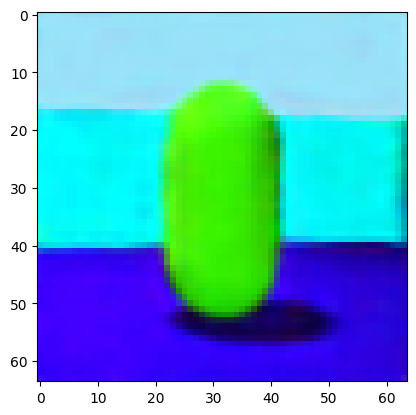

In [23]:
plt.imshow(recon[0].detach().cpu().permute(1,2,0))

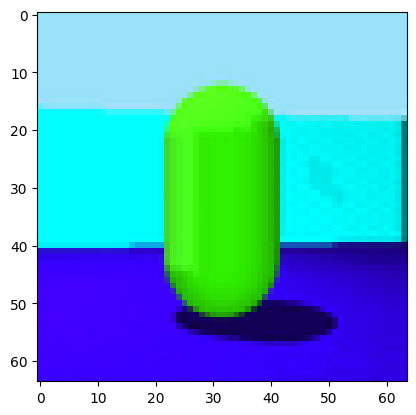

In [18]:
plt.imshow(usimgs[17].permute(1,2,0))

In [54]:
def get_q(model,l):
    #model = ae
    model.eval()
    q = torch.zeros(6,64)
    q[0] = model.vq1._embedding.weight[l[0]]
    q[1] = model.vq2._embedding.weight[l[1]]
    q[2] = model.vq3._embedding.weight[l[2]]
    q[3] = model.vq4._embedding.weight[l[3]]
    q[4] = model.vq5._embedding.weight[l[4]]
    q[5] = model.vq6._embedding.weight[l[5]]
    #print(q.shape)
    im = model.decoder(q.view(1,6,8,8).cuda())
    #print(im.squeeze(0).shape)
    return im.squeeze(0),q
    
def latent_traversal(model,latent_size = 6,nlatents = [10,10,10,8,4,15]):
    model.eval()
    img_list = []
    with torch.no_grad():
        for i in range(6):
            temp_list = []
            #et = torch.tensor([ 0,  2,  7,  3,  3, 0])
            et = torch.tensor([ 3, 0 ,  6,  7,  0, 10])

            for j in range(15):
                et[i] = j%nlatents[i]
                im,q = get_q(ae,et)
                temp_list.append(im.detach().cpu().permute(1,2,0))
            img_list.append(temp_list)

    return img_list
                
                
                
                
        
        

In [35]:
im_list =  latent_traversal(ae,latent_size = 6,nlatents = [10,10,10,8,4,15])


In [361]:
len(im_list[0])

15

In [ ]:
floor hue: 10 values linearly spaced in [0, 1]
wall hue: 10 values linearly spaced in [0, 1]
object hue: 10 values linearly spaced in [0, 1]
scale: 8 values linearly spaced in [0, 1]
shape: 4 values in [0, 1, 2, 3]
orientation: 15 values linearly spaced in [-30, 30]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

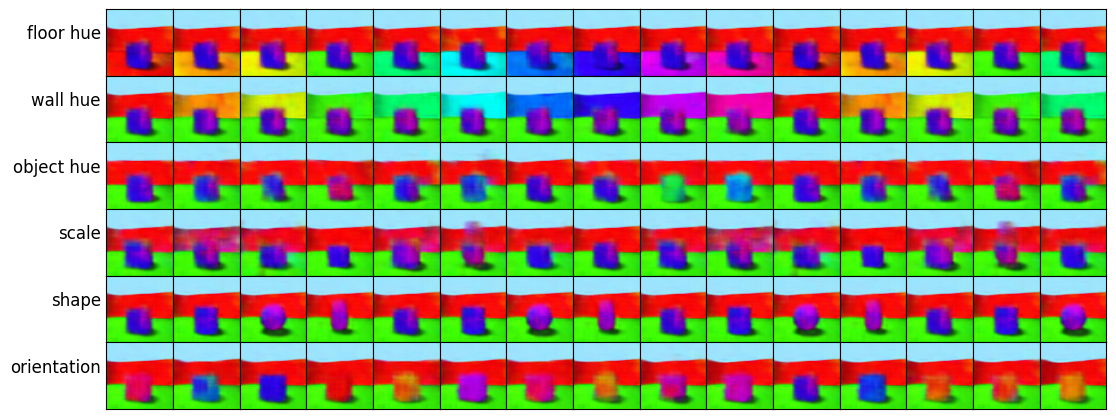

/home/ksanka/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ksanka/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [62]:
from numpy.random import rand
import matplotlib.pyplot as plt

ylabels = ["floor hue","wall hue","object hue","scale",
           "shape","orientation"]#,"camera_z-pos"]
heights = [a[0].shape[0] for a in im_list]
widths = [a.shape[1] for a in im_list[0]]

fig_width = 10.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(6,15, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(6):
    for j in range(15):
        axarr[i, j].imshow(im_list[i][j])
        axarr[i, j].grid(False)
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
        #axarr[i, j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
for ax, mode in zip(axarr[:, 0], ylabels):
    ax.set_ylabel(mode, size=12,rotation = 0,ha = "right")
#plt.savefig("shapes3d_latent_traversal_with_labels2.pdf",bbox_inches='tight', dpi=300)

plt.show()

In [37]:
tset,tlabels,_ = ds.get_t_batch(5000)

In [39]:
tset.shape

torch.Size([5000, 3, 64, 64])

In [55]:
#tset,tlabels,traw_labels = get_data(5000,'cpu',True)#next(iter(test_loader))
def eval(model):
    model.eval
    #ev_data = test_set[:250].to(device)
    ev_data = tset[:250].to(device)

    with torch.no_grad():
        _,_,_,_,ei_list,_ = model(ev_data.to(device))
        latent = torch.cat(ei_list,1) + torch.tensor([0,10,20,30,38,42],device = device)
        #print(latent.shape)
        for i in range(1,20):
            _,_,_,_,ei_list,_ = model(tset[i*250:(i+1)*250].to(device))
            z = torch.cat(ei_list,1) + torch.tensor([0,10,20,30,38,42],device = device)
            latent = torch.cat([latent,z],0)
    #print(latent.shape)
    
    res = compute_infomec(tlabels.cpu().numpy(), latent.float().detach().cpu().numpy(), True)
    return res

In [22]:
ae.eval()
ev_data = tset[:250].to(device)

with torch.no_grad():
    a,b,c,d,e,ei_list = ae(ev_data.to(device))

In [26]:
torch.cat(e,1)

tensor([[ 0,  3,  6,  4,  2, 10],
        [ 8,  5,  2,  6,  3,  4],
        [ 5,  3,  9,  5,  1,  1],
        ...,
        [ 8,  8,  4,  6,  1,  0],
        [ 6,  1,  1,  0,  2,  2],
        [ 6,  1,  1,  0,  0,  1]], device='cuda:0')

In [60]:
res = eval(ae)

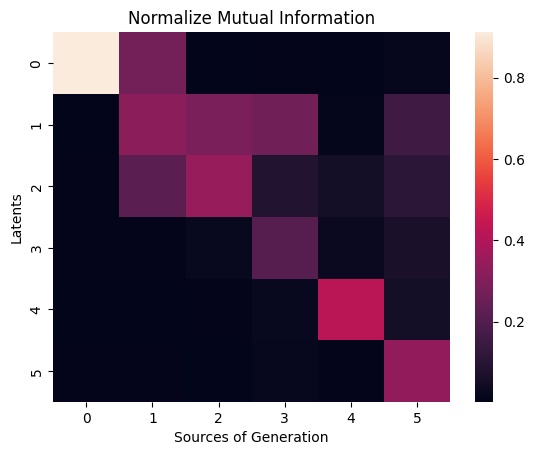

In [65]:
sns.heatmap(res['nmi'])
plt.xlabel('Sources of Generation')
plt.ylabel('Latents')
plt.title('Normalize Mutual Information')
plt.savefig('2missing_attributes.pdf')


In [39]:
res

{'infom': 0.980915259434189,
 'infoe': 0.999999959318178,
 'infoc': 0.980886257355383,
 'nmi': array([[1.        , 0.00246718, 0.00377335, 0.00213399, 0.00109507,
         0.00512981],
        [0.00246718, 1.        , 0.00366532, 0.00373171, 0.00123298,
         0.00622398],
        [0.00377335, 0.00366532, 1.        , 0.00283353, 0.0010618 ,
         0.00588005],
        [0.00236299, 0.00413215, 0.0031376 , 1.        , 0.00118856,
         0.00564058],
        [0.00181887, 0.00204794, 0.00176361, 0.00178284, 1.        ,
         0.00342251],
        [0.00436174, 0.00529209, 0.00499966, 0.00433126, 0.00175204,
         1.        ]]),
 'active_latents': array([ True,  True,  True,  True,  True,  True])}

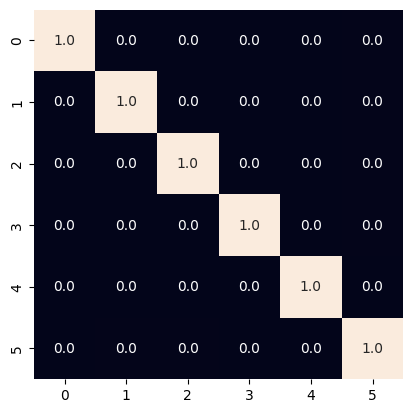

In [49]:
hmap = sns.heatmap(res['nmi'],annot = True,fmt='.1f',cbar = False,square= True)
fig = hmap.get_figure()    
#figure.savefig('svm_conf.png', dpi=400)
fig.savefig("shapes3d_nmi_wo_cbar.pdf",dpi = 300,bbox_inches='tight') 

<Axes: >

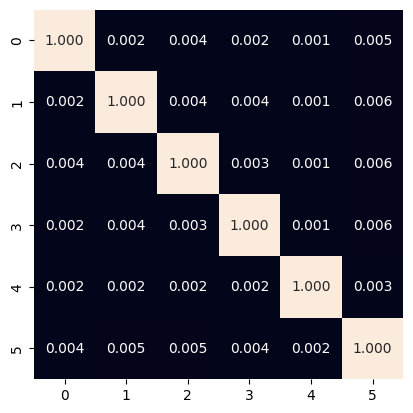

In [41]:
import seaborn as sns
sns.heatmap(res['nmi'],annot = True,fmt='.3f',cbar = False,square= True)

In [350]:
im_list[0][0].shape

torch.Size([64, 64, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


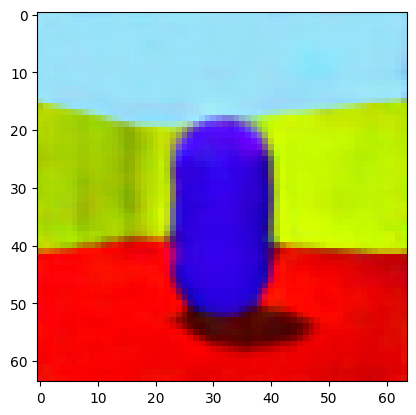

In [366]:
plt.imshow(im_list[5][14])

In [43]:
ae.vq1._embedding.weight[0]

tensor([-0.0446,  0.0951, -0.1357, -0.2000,  0.1382,  0.1586,  0.0833, -0.0682,
        -0.1340,  0.1934,  0.0236, -0.2756,  0.1124, -0.0632,  0.0570, -0.1441,
         0.0211,  0.2188, -0.1736,  0.3084, -0.0726, -0.0931,  0.0687,  0.0497,
        -0.0469, -0.0103, -0.0467,  0.1867,  0.2570,  0.0045,  0.2197,  0.0525,
         0.2471, -0.0684, -0.1728,  0.0912,  0.0441,  0.0162,  0.2313,  0.0758,
         0.0371,  0.0718,  0.0407, -0.1271, -0.0045,  0.0024,  0.0935,  0.0031,
        -0.0187, -0.0041, -0.0925,  0.2801,  0.1303, -0.1117,  0.0348,  0.0549,
        -0.0360,  0.0119,  0.0182, -0.0915,  0.0107, -0.0718, -0.1228,  0.0322],
       device='cuda:0')

In [45]:
q = torch.zeros(15,6,64)
q[0].shape

torch.Size([64])

In [112]:
ae.vq1._embedding.weight.shape

torch.Size([10, 64])

In [218]:
def get_q(model,l):
    #model = ae
    model.eval()
    q = torch.zeros(6,64)
    q[0] = model.vq1._embedding.weight[l[0]]
    q[1] = model.vq2._embedding.weight[l[1]]
    q[2] = model.vq3._embedding.weight[l[2]]
    q[3] = model.vq4._embedding.weight[l[3]]
    q[4] = model.vq5._embedding.weight[l[4]]
    q[5] = model.vq6._embedding.weight[l[5]]
    #print(q.shape)
    im = model.decoder(q.view(1,6,8,8).cuda())
    #print(im.squeeze(0).shape)
    return im.squeeze(0),q
    
    

In [214]:
torch.abs(quant[0].cpu().detach() - q.view(6,8,8)).sum()

tensor(2.9654e-06)

In [247]:
tr_img[0]

NameError: name 'tr_img' is not defined

In [209]:
quant[0]

tensor([[[ 4.7527e-02,  4.8333e-02,  1.6535e-02,  2.3979e-02,  1.3990e-01,
          -1.8411e-02,  2.2863e-02, -5.8678e-02],
         [ 2.3500e-02, -1.5395e-01,  3.7974e-02,  3.1973e-02, -1.1114e-01,
           7.9519e-02, -5.0125e-03, -1.7250e-01],
         [ 6.8981e-02,  7.7690e-03,  1.5810e-01,  7.7176e-02, -7.6791e-02,
          -3.5459e-02, -4.5057e-02, -3.2417e-02],
         [ 1.9776e-01,  5.2768e-03,  1.3473e-01, -9.3751e-03, -2.5666e-01,
          -8.7119e-03, -6.3339e-02, -1.9893e-01],
         [ 7.4512e-02,  9.1982e-02, -2.8048e-01, -6.9750e-02,  1.3490e-01,
          -1.3820e-01,  8.9307e-02, -7.2928e-02],
         [ 7.3389e-02,  8.9411e-04, -1.0461e-01,  5.3489e-02,  8.2912e-02,
          -1.6364e-01,  1.4940e-01,  3.2100e-01],
         [ 9.0035e-02, -1.5023e-01,  1.3642e-01, -3.2094e-01, -1.5900e-01,
           1.9670e-02,  1.9491e-01,  3.0425e-02],
         [-4.9584e-02, -7.8405e-03, -3.6752e-02,  3.2075e-02, -1.1504e-01,
          -1.2345e-01, -5.5061e-02,  3.2087e-01]],

In [339]:
im,q = get_q(ae,torch.tensor([ 0,  2,  7,  3,  3, 0]))

In [337]:
im,q = get_q(ae,torch.tensor([ 2,  0,  0,  0,  0, 0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


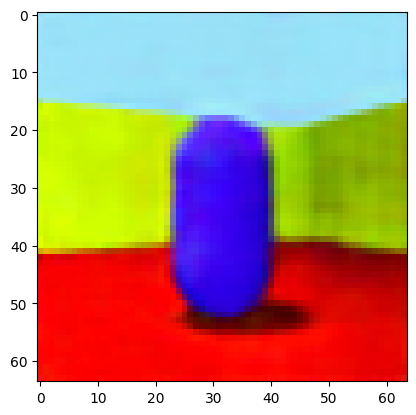

In [340]:
plt.imshow(im.permute(1,2,0).cpu().data)

In [82]:
batch_get_q = torch.vmap(get_q,0)
bq = batch_get_q(ind)

RuntimeError: vmap: It looks like you're calling .item() on a Tensor. We don't support vmap over calling .item() on a Tensor, please try to rewrite what you're doing with other operations. If error is occurring somewhere inside PyTorch internals, please file a bug report.

In [ ]:
q = get_q(ae,ind)

In [74]:
ind = torch.tensor([0,0,0,0,0,0]).unsqueeze(0).repeat(15,1)
s = torch.arange(15)%10
ind.shape,s.shape
ind[:,-1]+=s

In [124]:
encodings = torch.zeros(ind.shape[0], 10, device='cpu')
encodings.scatter_(1, ind, 1)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [121]:
encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings)
encodings.scatter_(1, encoding_indices, 1)

NameError: name 'encoding_indices' is not defined

In [88]:
encodings.shape

torch.Size([15, 64])

In [62]:
q.shape

torch.Size([1, 3, 64, 64])

In [38]:
encodings = torch.zeros(6, 64, device='cuda')
encodings.scatter_(1, torch.tensor([0,0,0,0,0,0],device = 'cuda'), 1)

RuntimeError: Index tensor must have the same number of dimensions as self tensor

In [34]:
encodings.shape

torch.Size([6, 64])

In [324]:
ae = AE(120,64,0.25).to(device)
ae.load_state_dict(torch.load('shapes3d_5k_sup_cos.pt'))
#optimizer = optim.Adam(ae.parameters(), lr=0.001, amsgrad=False)
optimizer = optim.AdamW(ae.parameters(), lr=0.0001, weight_decay=0.3)
for name, param in ae.named_parameters():
    if "bias" in name:
        param.weight_decay = 0
    if "embedding" in name:
        param.weight_decay = 0
step = 0
for i in tqdm.tqdm(range(10000),ncols = 100):
    step+=1
    perm = torch.randint(0,40000,(64,))

    #perm = torch.randint(0,size,(64,))
    optimizer.zero_grad()

    #if training_mode == "s":
    recon, quant,loss_list,perp_list,ei_list,elist = ae(usimgs[perm].to(device))#,trlabels[perm].to(device))
    #recon_loss = F.binary_cross_entropy_with_logits(recon,trimgs[perm].to(device),reduction = 'mean')
    recon_loss = F.mse_loss(recon,usimgs[perm].to(device),reduction = 'mean')

    # else:
    #     recon, loss_list,perp_list,ei_list = ae(usimgs[perm].to(device))#,trone_hot_labels[perm].to(device))
    #     #recon_loss = F.binary_cross_entropy_with_logits(recon, usimgs[perm].to(device))
    #     recon_loss = F.mse_loss(recon, usimgs[perm].to(device))


    vq_loss = sum(loss_list)
    loss = recon_loss + vq_loss/6.
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(ae.parameters(), max_norm=1.0)

    optimizer.step()

    #recon_list.append(loss.item())
    if step %100 == 0:
        print(loss.item())
        print(recon_loss.item())
        print(loss_list)
        # break

  1%|▌                                                          | 104/10000 [00:03<05:20, 30.90it/s]

0.04785005748271942
0.002233168575912714
[tensor(0.0526, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0189, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0799, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0638, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0186, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0399, device='cuda:0', grad_fn=<MeanBackward0>)]


  2%|█▏                                                         | 204/10000 [00:06<05:17, 30.87it/s]

0.04864301532506943
0.0026622340083122253
[tensor(0.0545, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0208, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0835, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0628, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0190, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0353, device='cuda:0', grad_fn=<MeanBackward0>)]


  3%|█▊                                                         | 312/10000 [00:08<02:42, 59.59it/s]

0.04824763163924217
0.0023576789535582066
[tensor(0.0539, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0192, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0821, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0644, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0179, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0377, device='cuda:0', grad_fn=<MeanBackward0>)]


  4%|██▎                                                        | 401/10000 [00:11<05:21, 29.83it/s]

0.04766450449824333
0.0018580688629299402
[tensor(0.0517, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0165, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0834, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0658, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0167, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0408, device='cuda:0', grad_fn=<MeanBackward0>)]


  5%|██▉                                                        | 501/10000 [00:14<05:14, 30.18it/s]

0.04825267195701599
0.002569445874541998
[tensor(0.0512, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0204, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0760, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0681, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0185, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0400, device='cuda:0', grad_fn=<MeanBackward0>)]


  6%|███▌                                                       | 601/10000 [00:17<05:18, 29.51it/s]

0.044711966067552567
0.0021782885305583477
[tensor(0.0483, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0165, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0751, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0571, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0216, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0366, device='cuda:0', grad_fn=<MeanBackward0>)]


  7%|████▏                                                      | 703/10000 [00:19<05:04, 30.57it/s]

0.044678475707769394
0.0030787154100835323
[tensor(0.0514, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0160, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0722, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0548, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0187, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0365, device='cuda:0', grad_fn=<MeanBackward0>)]


  8%|████▋                                                      | 803/10000 [00:22<05:17, 28.93it/s]

0.045307546854019165
0.002599045168608427
[tensor(0.0534, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0173, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0789, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0557, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0177, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0332, device='cuda:0', grad_fn=<MeanBackward0>)]


  9%|█████▎                                                     | 903/10000 [00:25<05:12, 29.14it/s]

0.04502061381936073
0.0017857491038739681
[tensor(0.0543, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0162, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0729, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0643, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0164, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0352, device='cuda:0', grad_fn=<MeanBackward0>)]


 10%|█████▊                                                    | 1003/10000 [00:28<04:16, 35.11it/s]

0.04391995444893837
0.001809332286939025
[tensor(0.0472, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0175, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0755, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0567, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0169, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0389, device='cuda:0', grad_fn=<MeanBackward0>)]


 11%|██████▍                                                   | 1103/10000 [00:31<05:01, 29.48it/s]

0.04280547425150871
0.0018517629941925406
[tensor(0.0480, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0174, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0759, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0482, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0171, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0391, device='cuda:0', grad_fn=<MeanBackward0>)]


 12%|██████▉                                                   | 1203/10000 [00:34<05:03, 28.98it/s]

0.04521149769425392
0.0021002786234021187
[tensor(0.0480, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0182, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0807, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0552, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0207, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0359, device='cuda:0', grad_fn=<MeanBackward0>)]


 13%|███████▌                                                  | 1303/10000 [00:37<05:10, 28.04it/s]

0.04536335915327072
0.0021748621948063374
[tensor(0.0595, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0175, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0721, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0528, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0192, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0380, device='cuda:0', grad_fn=<MeanBackward0>)]


 14%|████████▏                                                 | 1401/10000 [00:39<02:50, 50.49it/s]

0.046528637409210205
0.002990858629345894
[tensor(0.0529, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0171, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0777, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0524, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0189, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0422, device='cuda:0', grad_fn=<MeanBackward0>)]


 15%|████████▋                                                 | 1503/10000 [00:42<04:53, 28.92it/s]

0.042782627046108246
0.0027532416861504316
[tensor(0.0510, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0166, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0724, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0460, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0189, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0352, device='cuda:0', grad_fn=<MeanBackward0>)]


 16%|█████████▎                                                | 1603/10000 [00:45<04:54, 28.50it/s]

0.04278884828090668
0.0019520295318216085
[tensor(0.0485, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0174, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0731, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0496, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0197, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0368, device='cuda:0', grad_fn=<MeanBackward0>)]


 17%|█████████▉                                                | 1703/10000 [00:48<04:57, 27.84it/s]

0.04295788332819939
0.0017676765564829111
[tensor(0.0472, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0142, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0733, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0613, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0173, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)]


 18%|██████████▍                                               | 1801/10000 [00:50<03:03, 44.70it/s]

0.04273030534386635
0.0019157405477017164
[tensor(0.0477, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0156, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0744, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0588, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0179, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0305, device='cuda:0', grad_fn=<MeanBackward0>)]


 19%|███████████                                               | 1902/10000 [00:53<04:43, 28.60it/s]

0.04292234778404236
0.002173586515709758
[tensor(0.0462, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0171, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0760, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0542, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0171, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0341, device='cuda:0', grad_fn=<MeanBackward0>)]


 20%|███████████▌                                              | 2002/10000 [00:56<04:25, 30.11it/s]

0.042185038328170776
0.0027701794169843197
[tensor(0.0453, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0166, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0770, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0500, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0154, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0322, device='cuda:0', grad_fn=<MeanBackward0>)]


 21%|████████████▏                                             | 2102/10000 [00:59<04:33, 28.89it/s]

0.04212641343474388
0.0023581786081194878
[tensor(0.0504, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0146, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0721, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0495, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0192, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0328, device='cuda:0', grad_fn=<MeanBackward0>)]


 22%|████████████▊                                             | 2202/10000 [01:01<03:33, 36.58it/s]

0.043360475450754166
0.0027220523916184902
[tensor(0.0458, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0174, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0744, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0486, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0183, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0392, device='cuda:0', grad_fn=<MeanBackward0>)]


 23%|█████████████▎                                            | 2302/10000 [01:04<04:22, 29.37it/s]

0.04483911395072937
0.00305129773914814
[tensor(0.0436, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0191, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0786, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0552, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0174, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0368, device='cuda:0', grad_fn=<MeanBackward0>)]


 24%|█████████████▉                                            | 2402/10000 [01:07<04:27, 28.39it/s]

0.042251259088516235
0.0018597589805722237
[tensor(0.0436, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0160, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0698, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0634, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0169, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0327, device='cuda:0', grad_fn=<MeanBackward0>)]


 25%|██████████████▌                                           | 2502/10000 [01:10<04:17, 29.10it/s]

0.04227365553379059
0.002363300882279873
[tensor(0.0455, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0169, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0687, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0581, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0203, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0301, device='cuda:0', grad_fn=<MeanBackward0>)]


 26%|███████████████                                           | 2602/10000 [01:12<04:12, 29.35it/s]

0.04215118661522865
0.002221909584477544
[tensor(0.0419, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0865, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0495, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0177, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0288, device='cuda:0', grad_fn=<MeanBackward0>)]


 27%|███████████████▋                                          | 2702/10000 [01:15<04:25, 27.46it/s]

0.03925305977463722
0.002192992251366377
[tensor(0.0389, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0154, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0716, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0458, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0185, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0322, device='cuda:0', grad_fn=<MeanBackward0>)]


 28%|████████████████▎                                         | 2802/10000 [01:18<04:17, 28.00it/s]

0.04426048696041107
0.0029778785537928343
[tensor(0.0425, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0174, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0822, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0487, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0199, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0368, device='cuda:0', grad_fn=<MeanBackward0>)]


 29%|████████████████▊                                         | 2907/10000 [01:21<01:59, 59.54it/s]

0.040340691804885864
0.001877864240668714
[tensor(0.0449, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0157, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0763, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0464, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0182, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0292, device='cuda:0', grad_fn=<MeanBackward0>)]


 30%|█████████████████▍                                        | 3001/10000 [01:24<03:45, 31.04it/s]

0.041690852493047714
0.002154629211872816
[tensor(0.0387, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0163, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0748, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0532, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0182, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0361, device='cuda:0', grad_fn=<MeanBackward0>)]


 31%|█████████████████▉                                        | 3101/10000 [01:27<03:48, 30.19it/s]

0.039829596877098083
0.0018619652837514877
[tensor(0.0409, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0153, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0677, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0490, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0185, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0364, device='cuda:0', grad_fn=<MeanBackward0>)]


 32%|██████████████████▌                                       | 3201/10000 [01:29<03:55, 28.84it/s]

0.04113023355603218
0.0018665781244635582
[tensor(0.0465, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0158, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0741, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0511, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0174, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0307, device='cuda:0', grad_fn=<MeanBackward0>)]


 33%|███████████████████▏                                      | 3304/10000 [01:32<03:39, 30.48it/s]

0.04154613986611366
0.0026492890901863575
[tensor(0.0424, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0195, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0688, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0526, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0183, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0318, device='cuda:0', grad_fn=<MeanBackward0>)]


 34%|███████████████████▋                                      | 3403/10000 [01:35<03:50, 28.58it/s]

0.04140906780958176
0.0019594370387494564
[tensor(0.0456, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0146, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0725, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0525, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0177, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0338, device='cuda:0', grad_fn=<MeanBackward0>)]


 35%|████████████████████▎                                     | 3503/10000 [01:38<03:42, 29.23it/s]

0.039532117545604706
0.0020509420428425074
[tensor(0.0454, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0181, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0637, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0454, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0193, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0330, device='cuda:0', grad_fn=<MeanBackward0>)]


 36%|████████████████████▉                                     | 3610/10000 [01:41<01:59, 53.54it/s]

0.04228757694363594
0.00251521123573184
[tensor(0.0432, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0161, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0742, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0534, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0187, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0330, device='cuda:0', grad_fn=<MeanBackward0>)]


 37%|█████████████████████▍                                    | 3706/10000 [01:43<03:09, 33.13it/s]

0.04207518324255943
0.0023166374303400517
[tensor(0.0476, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0208, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0658, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0490, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0178, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0376, device='cuda:0', grad_fn=<MeanBackward0>)]


 38%|██████████████████████                                    | 3803/10000 [01:46<03:29, 29.64it/s]

0.04165946692228317
0.002047767397016287
[tensor(0.0404, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0155, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0837, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0445, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0234, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0303, device='cuda:0', grad_fn=<MeanBackward0>)]


 39%|██████████████████████▋                                   | 3903/10000 [01:49<03:29, 29.13it/s]

0.04159119352698326
0.002159725409001112
[tensor(0.0457, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0196, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0698, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0505, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0196, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0313, device='cuda:0', grad_fn=<MeanBackward0>)]


 40%|███████████████████████▏                                  | 4004/10000 [01:52<02:41, 37.03it/s]

0.03764629364013672
0.002048896625638008
[tensor(0.0398, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0149, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0691, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0427, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0166, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0306, device='cuda:0', grad_fn=<MeanBackward0>)]


 41%|███████████████████████▊                                  | 4104/10000 [01:55<03:14, 30.32it/s]

0.03914780169725418
0.002051709219813347
[tensor(0.0406, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0166, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0678, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0469, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0180, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0327, device='cuda:0', grad_fn=<MeanBackward0>)]


 42%|████████████████████████▍                                 | 4204/10000 [01:58<03:01, 32.02it/s]

0.04184619337320328
0.0026353816501796246
[tensor(0.0415, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0197, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0719, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0459, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0220, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0344, device='cuda:0', grad_fn=<MeanBackward0>)]


 43%|████████████████████████▉                                 | 4304/10000 [02:01<03:05, 30.65it/s]

0.04196499288082123
0.0024303037207573652
[tensor(0.0454, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0168, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0732, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0492, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0191, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0335, device='cuda:0', grad_fn=<MeanBackward0>)]


 44%|█████████████████████████▌                                | 4402/10000 [02:03<02:50, 32.82it/s]

0.03875165805220604
0.0018733600154519081
[tensor(0.0417, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0159, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0727, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0441, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0182, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>)]


 45%|██████████████████████████                                | 4502/10000 [02:06<03:07, 29.37it/s]

0.03893619403243065
0.00182146648876369
[tensor(0.0405, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0155, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0681, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0451, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0212, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0322, device='cuda:0', grad_fn=<MeanBackward0>)]


 46%|██████████████████████████▋                               | 4602/10000 [02:09<03:07, 28.79it/s]

0.04022429510951042
0.001655068015679717
[tensor(0.0427, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0167, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0671, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0521, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0204, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0325, device='cuda:0', grad_fn=<MeanBackward0>)]


 47%|███████████████████████████▎                              | 4702/10000 [02:12<02:57, 29.92it/s]

0.04397396743297577
0.0036353114992380142
[tensor(0.0426, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0192, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0798, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0493, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0207, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0305, device='cuda:0', grad_fn=<MeanBackward0>)]


 48%|███████████████████████████▊                              | 4803/10000 [02:14<02:59, 28.95it/s]

0.038096386939287186
0.0017641999293118715
[tensor(0.0375, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0170, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0658, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0478, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0208, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0291, device='cuda:0', grad_fn=<MeanBackward0>)]


 49%|████████████████████████████▍                             | 4903/10000 [02:17<03:00, 28.19it/s]

0.039525121450424194
0.002527229255065322
[tensor(0.0388, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0159, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0681, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0431, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0218, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0343, device='cuda:0', grad_fn=<MeanBackward0>)]


 50%|█████████████████████████████                             | 5003/10000 [02:20<02:48, 29.63it/s]

0.039472080767154694
0.0018179611070081592
[tensor(0.0401, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0158, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0689, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0492, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0207, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0311, device='cuda:0', grad_fn=<MeanBackward0>)]


 51%|█████████████████████████████▌                            | 5107/10000 [02:23<01:24, 58.16it/s]

0.03738229349255562
0.0018882829463109374
[tensor(0.0395, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0159, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0674, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0426, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0202, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0275, device='cuda:0', grad_fn=<MeanBackward0>)]


 52%|██████████████████████████████▏                           | 5202/10000 [02:26<02:48, 28.45it/s]

0.037375278770923615
0.0017029563896358013
[tensor(0.0374, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0154, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0617, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0433, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0224, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0338, device='cuda:0', grad_fn=<MeanBackward0>)]


 53%|██████████████████████████████▊                           | 5302/10000 [02:29<02:47, 28.01it/s]

0.03923808038234711
0.0016501679783686996
[tensor(0.0392, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0166, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0645, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0522, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0226, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0305, device='cuda:0', grad_fn=<MeanBackward0>)]


 54%|███████████████████████████████▎                          | 5405/10000 [02:31<02:17, 33.44it/s]

0.042098261415958405
0.0016750197391957045
[tensor(0.0393, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0174, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0843, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0442, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0252, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0322, device='cuda:0', grad_fn=<MeanBackward0>)]


 55%|███████████████████████████████▉                          | 5513/10000 [02:34<01:10, 63.46it/s]

0.04065444692969322
0.0019365537445992231
[tensor(0.0393, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0705, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0501, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0233, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)]


 56%|████████████████████████████████▍                         | 5601/10000 [02:36<02:32, 28.90it/s]

0.0400875024497509
0.0017883041873574257
[tensor(0.0396, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0145, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0713, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0449, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0243, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0353, device='cuda:0', grad_fn=<MeanBackward0>)]


 57%|█████████████████████████████████                         | 5702/10000 [02:39<02:30, 28.52it/s]

0.03848022595047951
0.0023530148901045322
[tensor(0.0380, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0162, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0694, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0443, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0207, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0282, device='cuda:0', grad_fn=<MeanBackward0>)]


 58%|█████████████████████████████████▋                        | 5802/10000 [02:42<02:21, 29.57it/s]

0.03672347962856293
0.002019653096795082
[tensor(0.0387, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0137, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0685, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0374, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0191, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0308, device='cuda:0', grad_fn=<MeanBackward0>)]


 59%|██████████████████████████████████▏                       | 5901/10000 [02:45<02:07, 32.26it/s]

0.039228327572345734
0.0020376695320010185
[tensor(0.0390, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0183, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0705, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0461, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0202, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0290, device='cuda:0', grad_fn=<MeanBackward0>)]


 60%|██████████████████████████████████▊                       | 6001/10000 [02:48<02:12, 30.09it/s]

0.03935245797038078
0.0022711390629410744
[tensor(0.0397, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0145, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0730, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0435, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0214, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0303, device='cuda:0', grad_fn=<MeanBackward0>)]


 61%|███████████████████████████████████▍                      | 6102/10000 [02:51<02:09, 30.03it/s]

0.043607134371995926
0.0037234982009977102
[tensor(0.0404, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0192, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0751, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0458, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0202, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0387, device='cuda:0', grad_fn=<MeanBackward0>)]


 62%|███████████████████████████████████▉                      | 6202/10000 [02:54<02:15, 28.04it/s]

0.03773496299982071
0.0025158931966871023
[tensor(0.0405, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0151, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0671, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0364, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0226, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>)]


 63%|████████████████████████████████████▌                     | 6303/10000 [02:56<02:10, 28.41it/s]

0.038928739726543427
0.0018783783307299018
[tensor(0.0398, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0147, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0691, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0414, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0235, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0339, device='cuda:0', grad_fn=<MeanBackward0>)]


 64%|█████████████████████████████████████▏                    | 6403/10000 [02:59<02:00, 29.73it/s]

0.03912188112735748
0.0017650483641773462
[tensor(0.0352, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0172, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0727, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0418, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0246, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0326, device='cuda:0', grad_fn=<MeanBackward0>)]


 65%|█████████████████████████████████████▋                    | 6503/10000 [03:02<01:51, 31.48it/s]

0.04024356231093407
0.0023291006218641996
[tensor(0.0395, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0181, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0641, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0485, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0230, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0341, device='cuda:0', grad_fn=<MeanBackward0>)]


 66%|██████████████████████████████████████▎                   | 6604/10000 [03:05<01:36, 35.37it/s]

0.0398697555065155
0.002620093058794737
[tensor(0.0411, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0184, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0683, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0418, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0217, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0322, device='cuda:0', grad_fn=<MeanBackward0>)]


 67%|██████████████████████████████████████▉                   | 6704/10000 [03:08<01:43, 31.91it/s]

0.037318482995033264
0.002033389639109373
[tensor(0.0377, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0139, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0696, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0418, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0216, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0272, device='cuda:0', grad_fn=<MeanBackward0>)]


 68%|███████████████████████████████████████▍                  | 6804/10000 [03:11<01:41, 31.53it/s]

0.037620753049850464
0.0017559907864779234
[tensor(0.0392, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0150, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0620, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0444, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0235, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0311, device='cuda:0', grad_fn=<MeanBackward0>)]


 69%|████████████████████████████████████████                  | 6904/10000 [03:14<01:37, 31.92it/s]

0.03948492556810379
0.0021802708506584167
[tensor(0.0415, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0140, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0675, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0455, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0216, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0337, device='cuda:0', grad_fn=<MeanBackward0>)]


 70%|████████████████████████████████████████▌                 | 7001/10000 [03:16<01:41, 29.41it/s]

0.038287729024887085
0.0016285026213154197
[tensor(0.0370, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0153, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0671, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0422, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0224, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0359, device='cuda:0', grad_fn=<MeanBackward0>)]


 71%|█████████████████████████████████████████▏                | 7101/10000 [03:19<01:35, 30.24it/s]

0.04125246778130531
0.0019242259440943599
[tensor(0.0417, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0201, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0714, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0450, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0266, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0311, device='cuda:0', grad_fn=<MeanBackward0>)]


 72%|█████████████████████████████████████████▊                | 7202/10000 [03:22<01:37, 28.57it/s]

0.03841327875852585
0.001870145439170301
[tensor(0.0359, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0144, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0660, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0457, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0248, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0324, device='cuda:0', grad_fn=<MeanBackward0>)]


 73%|██████████████████████████████████████████▎               | 7304/10000 [03:25<01:07, 40.23it/s]

0.0367232970893383
0.0015716435154899955
[tensor(0.0371, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0161, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0669, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0390, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0221, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>)]


 74%|██████████████████████████████████████████▉               | 7404/10000 [03:28<01:23, 31.12it/s]

0.0387154184281826
0.0019443370401859283
[tensor(0.0389, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0171, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0666, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0402, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0247, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0332, device='cuda:0', grad_fn=<MeanBackward0>)]


 75%|███████████████████████████████████████████▌              | 7504/10000 [03:31<01:19, 31.22it/s]

0.04006807506084442
0.0024829860776662827
[tensor(0.0369, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0176, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0719, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0414, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0235, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0342, device='cuda:0', grad_fn=<MeanBackward0>)]


 76%|████████████████████████████████████████████              | 7604/10000 [03:34<01:20, 29.82it/s]

0.03907746449112892
0.0024226238019764423
[tensor(0.0373, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0170, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0667, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0444, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0237, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0308, device='cuda:0', grad_fn=<MeanBackward0>)]


 77%|████████████████████████████████████████████▋             | 7704/10000 [03:36<01:08, 33.32it/s]

0.04039798676967621
0.0021801949478685856
[tensor(0.0356, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0158, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0683, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0497, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0347, device='cuda:0', grad_fn=<MeanBackward0>)]


 78%|█████████████████████████████████████████████▎            | 7804/10000 [03:39<01:10, 31.37it/s]

0.0370180606842041
0.001982947811484337
[tensor(0.0369, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0151, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0652, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0378, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0217, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0336, device='cuda:0', grad_fn=<MeanBackward0>)]


 79%|█████████████████████████████████████████████▊            | 7901/10000 [03:42<01:10, 29.77it/s]

0.036775559186935425
0.001878686947748065
[tensor(0.0358, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0169, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0612, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0376, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0325, device='cuda:0', grad_fn=<MeanBackward0>)]


 80%|██████████████████████████████████████████████▍           | 8001/10000 [03:45<01:08, 29.22it/s]

0.03899244964122772
0.002979760058224201
[tensor(0.0421, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0149, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0669, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0366, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0225, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0332, device='cuda:0', grad_fn=<MeanBackward0>)]


 81%|██████████████████████████████████████████████▉           | 8103/10000 [03:48<01:04, 29.57it/s]

0.037925560027360916
0.0018650635611265898
[tensor(0.0425, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0147, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0685, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0373, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0311, device='cuda:0', grad_fn=<MeanBackward0>)]


 82%|███████████████████████████████████████████████▌          | 8203/10000 [03:51<01:01, 29.14it/s]

0.042317453771829605
0.0023939209058880806
[tensor(0.0463, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0176, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0721, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0411, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0262, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0361, device='cuda:0', grad_fn=<MeanBackward0>)]


 83%|████████████████████████████████████████████████▏         | 8303/10000 [03:54<00:57, 29.58it/s]

0.035657159984111786
0.0014389331918209791
[tensor(0.0376, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0150, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0607, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0407, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0221, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0293, device='cuda:0', grad_fn=<MeanBackward0>)]


 84%|████████████████████████████████████████████████▋         | 8402/10000 [03:56<00:54, 29.41it/s]

0.03905237093567848
0.0023832551669329405
[tensor(0.0407, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0163, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0661, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0440, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0229, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0300, device='cuda:0', grad_fn=<MeanBackward0>)]


 85%|█████████████████████████████████████████████████▎        | 8503/10000 [03:59<00:51, 28.97it/s]

0.03831806778907776
0.0018960703164339066
[tensor(0.0367, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0165, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0680, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0369, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0279, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0327, device='cuda:0', grad_fn=<MeanBackward0>)]


 86%|█████████████████████████████████████████████████▉        | 8603/10000 [04:02<00:48, 28.82it/s]

0.037547409534454346
0.0018008550396189094
[tensor(0.0419, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0153, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0609, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0407, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0261, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>)]


 87%|██████████████████████████████████████████████████▌       | 8709/10000 [04:05<00:25, 50.18it/s]

0.04082344099879265
0.002857281593605876
[tensor(0.0369, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0186, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0689, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0424, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0327, device='cuda:0', grad_fn=<MeanBackward0>)]


 88%|███████████████████████████████████████████████████       | 8803/10000 [04:07<00:37, 31.54it/s]

0.038370199501514435
0.002085908083245158
[tensor(0.0393, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0161, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0653, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0413, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0233, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0324, device='cuda:0', grad_fn=<MeanBackward0>)]


 89%|███████████████████████████████████████████████████▋      | 8903/10000 [04:10<00:38, 28.65it/s]

0.04199402779340744
0.002476066118106246
[tensor(0.0418, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0184, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0711, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0415, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0313, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0330, device='cuda:0', grad_fn=<MeanBackward0>)]


 90%|████████████████████████████████████████████████████▏     | 9003/10000 [04:13<00:33, 29.36it/s]

0.0412091501057148
0.002735656453296542
[tensor(0.0363, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0207, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0719, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0441, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0266, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0313, device='cuda:0', grad_fn=<MeanBackward0>)]


 91%|████████████████████████████████████████████████████▊     | 9105/10000 [04:16<00:22, 38.93it/s]

0.038334496319293976
0.0017979205586016178
[tensor(0.0386, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0166, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0723, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0377, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0265, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>)]


 92%|█████████████████████████████████████████████████████▎    | 9202/10000 [04:19<00:27, 29.11it/s]

0.03611546382308006
0.001937029417604208
[tensor(0.0358, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0145, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0692, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0362, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0254, device='cuda:0', grad_fn=<MeanBackward0>)]


 93%|█████████████████████████████████████████████████████▉    | 9302/10000 [04:22<00:23, 29.74it/s]

0.041066497564315796
0.0021956288255751133
[tensor(0.0402, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0162, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0752, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0445, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0271, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0300, device='cuda:0', grad_fn=<MeanBackward0>)]


 94%|██████████████████████████████████████████████████████▌   | 9402/10000 [04:25<00:20, 29.88it/s]

0.03514531999826431
0.001751038245856762
[tensor(0.0390, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0159, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0615, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0338, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0228, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0274, device='cuda:0', grad_fn=<MeanBackward0>)]


 95%|███████████████████████████████████████████████████████   | 9503/10000 [04:27<00:15, 32.09it/s]

0.03731227293610573
0.002583752851933241
[tensor(0.0360, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0141, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0678, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0364, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0254, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>)]


 96%|███████████████████████████████████████████████████████▋  | 9603/10000 [04:30<00:13, 29.04it/s]

0.03775303065776825
0.0018639625050127506
[tensor(0.0406, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0157, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0650, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0371, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0274, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>)]


 97%|████████████████████████████████████████████████████████▎ | 9703/10000 [04:33<00:10, 28.95it/s]

0.03755137324333191
0.0015835892409086227
[tensor(0.0387, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0168, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0670, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0378, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0255, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0300, device='cuda:0', grad_fn=<MeanBackward0>)]


 98%|████████████████████████████████████████████████████████▉ | 9812/10000 [04:36<00:03, 59.77it/s]

0.03918382525444031
0.0018247526604682207
[tensor(0.0376, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0169, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0656, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0366, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0358, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0317, device='cuda:0', grad_fn=<MeanBackward0>)]


 99%|█████████████████████████████████████████████████████████▍| 9903/10000 [04:38<00:03, 31.18it/s]

0.03749644756317139
0.0016668091993778944
[tensor(0.0390, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0162, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0639, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0360, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0314, device='cuda:0', grad_fn=<MeanBackward0>)]


100%|█████████████████████████████████████████████████████████| 10000/10000 [04:41<00:00, 35.50it/s]

0.036690451204776764
0.0019376984564587474
[tensor(0.0357, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0172, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0623, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0383, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0264, device='cuda:0', grad_fn=<MeanBackward0>), tensor(0.0287, device='cuda:0', grad_fn=<MeanBackward0>)]


In [329]:
torch.save(ae.state_dict(),'shapes3d_10k_unsup_cos.pt')

In [10]:
ae.load_state_dict(torch.load('shapes3d_10k_unsup_cos.pt'))

<All keys matched successfully>

In [114]:
 l2norm(ae.vq1._embedding.weight)@l2norm(ae.vq1._embedding.weight).T


tensor([[ 1.0000e+00,  1.8626e-08,  1.8626e-08,  1.4901e-08,  1.4901e-08,
         -2.2352e-08,  1.9907e-08,  1.1176e-08,  1.0245e-08,  1.1176e-08],
        [ 1.8626e-08,  1.0000e+00, -9.3132e-09, -3.4459e-08, -5.5879e-09,
          5.9954e-09,  1.3970e-09,  1.8626e-09, -4.5984e-09, -6.5193e-09],
        [ 1.8626e-08, -9.3132e-09,  1.0000e+00,  1.6764e-08, -4.6566e-10,
         -1.1176e-08,  1.1176e-08, -1.4901e-08, -1.8626e-09,  3.7253e-09],
        [ 1.4901e-08, -3.4459e-08,  1.6764e-08,  1.0000e+00,  0.0000e+00,
          1.8626e-09, -1.3039e-08,  1.1176e-08,  3.7020e-08, -1.4901e-08],
        [ 1.4901e-08, -5.5879e-09, -4.6566e-10,  0.0000e+00,  1.0000e+00,
          5.2154e-08, -4.8429e-08,  3.1665e-08, -3.9116e-08,  2.2352e-08],
        [-2.2352e-08,  5.9954e-09, -1.1176e-08,  1.8626e-09,  5.2154e-08,
          1.0000e+00, -3.7253e-08,  2.2352e-08, -1.1176e-08, -1.4901e-08],
        [ 1.9907e-08,  1.3970e-09,  1.1176e-08, -1.3039e-08, -4.8429e-08,
         -3.7253e-08,  1.0000e+0

In [115]:
enc = ae.encoder(trimgs[perm].to(device))


In [52]:
enc.view(128,6,-1)

tensor([[[  3.9321,   6.9526,   7.4062,  ...,   6.9837,   6.4119,   5.4000],
         [ -6.5134,  -7.7737,  -5.9167,  ...,  -6.4097,  -7.0259,  -7.2359],
         [ -8.2250,  -0.7352,  -4.1030,  ..., -12.3253,  -9.2679,  -9.0479],
         [ -8.8374,  -8.2816,  -8.3126,  ...,  -7.6405, -11.7428,  -8.5557],
         [ -6.8783,  -7.6823,  -6.0189,  ..., -21.9244,  -6.5391,  -7.6772],
         [ -8.9636, -10.2200, -13.7866,  ...,  -8.8843, -10.1800,  -8.0171]],

        [[  4.3829,   7.2132,   7.8318,  ...,   2.3969,   1.9466,   1.3676],
         [ -7.8158,  -7.9664,  -7.3249,  ...,  -6.4844,  -7.6430,  -7.0772],
         [ -7.5439,  -0.1633,  -3.4607,  ...,  -9.3631,  -8.2417,  -8.2131],
         [ -7.8829,  -7.7154,  -7.6979,  ...,  -7.8212, -12.6797,  -6.3480],
         [ -6.4750,  -7.9674,  -6.7094,  ..., -13.0969, -10.3517,  -7.6526],
         [ -8.0259,  -8.1898,  -8.4176,  ..., -12.7575,  -9.0023,  -6.9763]],

        [[  4.3444,   7.3554,   7.7302,  ...,   2.0530,   1.5611,   1.23

In [123]:
q1 = l2norm(enc.view(-1,6,64)[:,0,:])@l2norm(ae.vq1._embedding.weight.T)
torch.argmax(q1,1)

tensor([7, 6, 0, 9, 7, 2, 7, 2, 8, 5, 3, 8, 9, 8, 4, 0, 8, 4, 5, 6, 6, 5, 7, 5,
        5, 8, 5, 5, 0, 4, 9, 3, 6, 4, 7, 1, 1, 3, 8, 8, 6, 5, 6, 2, 9, 2, 0, 4,
        0, 4, 0, 6, 6, 8, 7, 6, 0, 2, 1, 1, 6, 1, 6, 7], device='cuda:0')

In [117]:
trlabels[perm]

tensor([[ 7,  8,  4,  6,  1,  1],
        [ 6,  0,  2,  5,  0,  6],
        [ 0,  7,  3,  0,  1,  0],
        [ 9,  5,  5,  2,  2,  2],
        [ 7,  7,  8,  4,  3,  1],
        [ 2,  1,  7,  3,  1,  7],
        [ 7,  3,  8,  2,  0, 12],
        [ 2,  7,  8,  4,  2,  9],
        [ 8,  5,  2,  0,  3, 12],
        [ 5,  2,  5,  5,  1,  3],
        [ 3,  6,  9,  7,  0,  6],
        [ 8,  9,  9,  6,  3,  6],
        [ 9,  5,  7,  6,  0, 12],
        [ 8,  0,  0,  7,  1,  0],
        [ 4,  8,  2,  6,  0, 14],
        [ 0,  1,  2,  4,  3, 14],
        [ 8,  2,  1,  1,  2, 13],
        [ 4,  5,  7,  4,  2, 14],
        [ 5,  0,  4,  2,  0,  0],
        [ 6,  9,  8,  5,  1, 14],
        [ 6,  0,  5,  1,  2,  1],
        [ 5,  3,  9,  3,  0,  3],
        [ 7,  6,  9,  4,  2, 10],
        [ 5,  2,  0,  7,  2,  0],
        [ 5,  6,  6,  7,  1,  2],
        [ 8,  1,  3,  1,  1,  2],
        [ 5,  6,  4,  2,  0, 11],
        [ 5,  4,  6,  0,  1,  7],
        [ 0,  6,  0,  0,  1, 11],
        [ 4,  

In [11]:

def show(img):
    npimg = img.numpy()
    print(npimg.shape)
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='spline36')
    plt.figure(figsize=(10,100))

    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)



In [12]:
show(make_grid(recon[:16].cpu().data,))

NameError: name 'recon' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


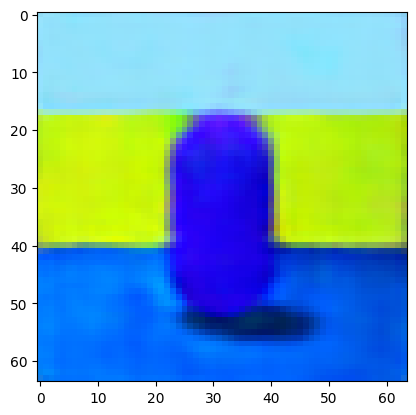

In [188]:
plt.imshow(recon[0].permute(1,2,0).cpu().data)

(3, 134, 530)


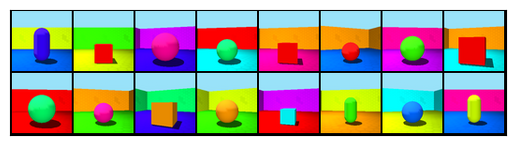

<Figure size 1000x10000 with 0 Axes>

In [183]:
show(make_grid(trimgs[perm][:16].cpu().data,))

(3, 134, 530)


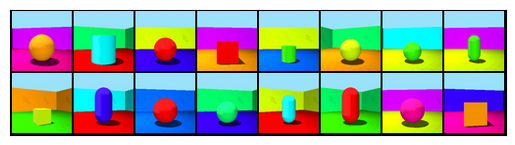

<Figure size 1000x10000 with 0 Axes>

In [303]:
show(make_grid(eimgs[:16].cpu().data,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 134, 530)


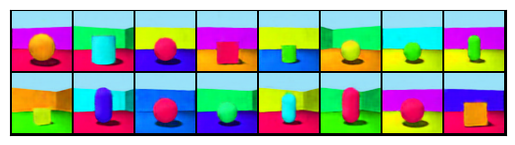

<Figure size 1000x10000 with 0 Axes>

In [302]:
show(make_grid(recon[:16].cpu().data,))

In [300]:
recon,quant, loss_list,perp_list,ei_list,elist = ae(eimgs[:16].to(device))#,elabels[:16].to(device))
#recon_loss = F.binary_cross_entropy_with_logits(recon,trimgs[perm].to(device),reduction = 'mean')
recon_loss = F.mse_loss(recon,eimgs[:16].to(device),reduction = 'mean')

In [301]:
recon_loss

tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward0>)

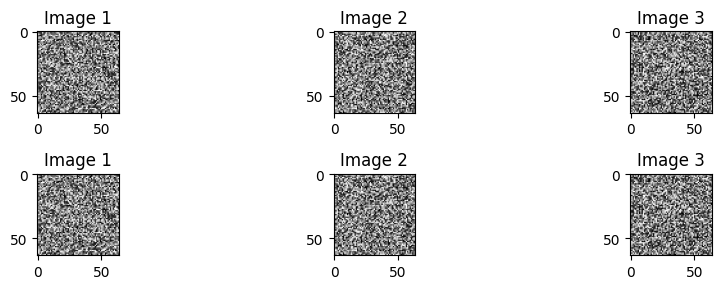

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Create some sample images
image1 = np.random.rand(64, 64)
image2 = np.random.rand(64, 64)
image3 = np.random.rand(64, 64)

# Create a figure and a common axis for the text
#fig, ax_text = plt.subplots()
#ax_text.text(0.5, 0.5, 'Common Text', ha='center', va='center', fontsize=14)

# Create subplots for the images
fig, axs = plt.subplots(2, 3, figsize=(10, 3))

# Plot the images
axs[0,0].imshow(image1, cmap='gray')
axs[0,0].set_title('Image 1')

axs[0,1].imshow(image2, cmap='gray')
axs[0,1].set_title('Image 2')

axs[0,2].imshow(image3, cmap='gray')
axs[0,2].set_title('Image 3')

axs[1,0].imshow(image1, cmap='gray')
axs[1,0].set_title('Image 1')

axs[1,1].imshow(image2, cmap='gray')
axs[1,1].set_title('Image 2')

axs[1,2].imshow(image3, cmap='gray')
axs[1,2].set_title('Image 3')
# Adjust layout to make room for the common axis with text
plt.tight_layout()

# Show the plot
plt.show()


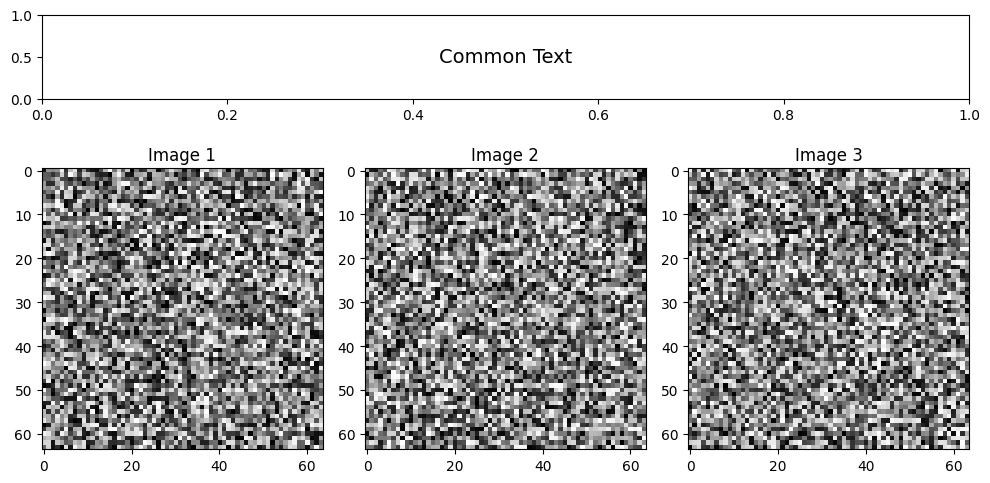

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Create some sample images
image1 = np.random.rand(64, 64)
image2 = np.random.rand(64, 64)
image3 = np.random.rand(64, 64)

# Create a figure and a GridSpec
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[0.2, 1])

# Add a common axis for the text at the top
ax_text = fig.add_subplot(gs[0, :])
ax_text.text(0.5, 0.5, 'Common Text', ha='center', va='center', fontsize=14)

# Create subplots for the images
axs = [fig.add_subplot(gs[1, i]) for i in range(3)]

# Plot the images
axs[0].imshow(image1, cmap='gray')
axs[0].set_title('Image 1')

axs[1].imshow(image2, cmap='gray')
axs[1].set_title('Image 2')

axs[2].imshow(image3, cmap='gray')
axs[2].set_title('Image 3')

# Adjust layout to make room for the common axis with text
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Show the plot
plt.show()
